# Bootstrapping gluon and heavy scalar amplitudes

In this notebook we will do a number of things. First we will systematically generate the most general ansatz for n point gluon and 2 massive scalar + n-2 gluon numerators, after that we will treat these two types of amplitudes but then with higher derivative corrections to the Yang-Mills theory, and in particular, when the momentum of the heavy scalar is much larger than the exchange momentum. We will then constrain the ansatzes using relevant physical constrains such as gauge invariance, factorization and symmetries.

The calculations are done using sympy (symbolic python). We will introduce new function when they are needed. First we treat pure yang mills amplitude, then go into massive scalars coupling to yang mills. Finally, we will also find amplitudes for theories with higher derivative corrections to yang mills.

Import packages:


In [1]:
import numpy as np
import itertools
from sympy import *
init_printing(use_unicode=True)

In contrast to mathematica, we need to define all variables before we use them in sympy. The objects that we use in the calculations of amplitudes and numerators are purely kinematic in nature. In other words, they consist of different contractions between momenta and polarization vectors. We will first generate all the possible objects for an n-point amplitude using the following functions:

Note that, depending on your text/code editor, there might be complaints that certain terms are not defined. This is due to the way we define all variables in a loop. This is not really a "pythonic" way of doing this, but in this case the best way of generating the variables. Hence the warnings can safely be ignored. If a variable is actually not defined, the code will not run and return an error.

In [2]:
def Generate_Symbols_kinematics_gluon(n):
    """Generate kinematic objects for scalar qcd calculations with n-2 gluons and and 2 heavy scalars. particle 1 and n are the heavy scalars. 
    Only generate objects that are generally non zero on shell (so no pi dot epsi for example)"""
    
    # lists for e, p variable and symbol names
    p_list = list(map(str,range(1,n+1)))
    eps_list = p_list

    variable_list = ['ee']*(np.arange(n)).sum() + ['pp']*(np.arange(n)).sum() + ['pe']*((n-1)*(n)) + ['s']*np.arange(n).sum()
    
    symbol_name_list = ['(e_{}\cdot\ e_{})']*(np.arange(n)).sum() + ['(p_{}\cdot\ p_{})']*(np.arange(n)).sum() + ['(p_{}\cdot\ e_{})']*((n-1)*(n)) + ['s_{}{}']*np.arange(n).sum() 

    iterator = 0
    
    # generate e dot e's
    for i in eps_list[:]:
        for k in eps_list[int(i)-1:]:
            if i!=k:
                symbol_name_list[iterator] = symbol_name_list[iterator].format('{'+str(i)+'}','{'+str(k)+'}')
                variable_list[iterator] = variable_list[iterator][0] + str(i) + variable_list[iterator][1] + str(k)
                iterator += 1

    # generate p dot p's
    for i in p_list:
        for k in p_list[int(i):]:
            symbol_name_list[iterator] = symbol_name_list[iterator].format('{'+p_list[int(i)-1]+'}','{'+p_list[int(k)-1]+'}')
            variable_list[iterator] = variable_list[iterator][0] + str(p_list[int(i)-1]+variable_list[iterator][1]+p_list[int(k)-1])
            iterator += 1

    # geneerate p dot e's
    for k in eps_list:
        for i in p_list:
            if eps_list[int(k)-2]!=p_list[int(i)-1]:
                symbol_name_list[iterator] = symbol_name_list[iterator].format('{'+p_list[int(i)-1]+'}','{'+eps_list[int(k)-2]+'}')
                variable_list[iterator] = variable_list[iterator][0] + str(p_list[int(i)-1]+variable_list[iterator][1]+eps_list[int(k)-2])

                iterator += 1

    # generate s'
    for i in p_list:
        for k in p_list[int(i):]:
            symbol_name_list[iterator] = symbol_name_list[iterator].format('{'+p_list[int(i)-1]+'}','{'+p_list[int(k)-1]+'}')
            variable_list[iterator] = variable_list[iterator] + str(p_list[int(i)-1]+p_list[int(k)-1])

            iterator += 1
    
    # uncomment the following line to test        
    # print(variable_list)
    
    # generate sympy sympols for lack of better way we do it in a for loop
    for i,var in enumerate(variable_list):
        globals()[var] = symbols(symbol_name_list[i])

Now the first real step is to find all the possible combinations of terms that could occur in a numerator corresponding to the amplitude of a yang mills theory. There is a number of important properties we want to satisfy.

- Each term most contain all external polarization vectors exactly ones. 
- Using conservation of momentum ($\sum p_i = 0$), we can eliminate one momentum all together, we will always choose to eliminate $p_n$
- From $m^2 = p_n^2 = (p_1+p_2+\ldots+p_{n-1})^2$, we can eliminate another term (m=0 for the pure yang-mills amplitudes)
- We can choose a powercounting (i.e. number of momenta in each numerator term) of the numerators, for a YM theory this will be 1 for each vertex (thus n-2 for an n point amplitude). Once we consider higher derivative corrections we can change this. 

Using some additional functions as defined below, we can generate all terms. For a low multiplicity this is not so many and easy to check by hand, but this quickly becomes quite a lot. This is also the reason we need to be using a symbolic programming language in the first place.


In [3]:
def Ans_pol_term(indices,n):
    """Generate ansatz terms from the indices of the generation array"""
    ansatz = ''
    if indices[0] < n:
        ansatz += 'e'+str(indices[0]+1)
    else:
        ansatz += 'p'+str(indices[0]-n+1)
    ansatz += 'e'+str(indices[1]+1)
    return ansatz

def Ans_pol_term_massive(indices,n):
    """Generate ansatz terms from the indices of the generation array"""
    ansatz = ''
    if indices[0] < n:
        ansatz += 'e'+str(indices[0]+2)
    else:
        ansatz += 'p'+str(indices[0]-n+1)
    ansatz += 'e'+str(indices[1]+2)
    return ansatz

def iter_combinations(input_array,possible_array): 
    # return all possible combinations of the input array with the possible array
    a = input_array
    b = possible_array
    pos_result = []
    for i in a:
        for j in b:
            pos_result.append(i+' '+j)
        b = b[1:]
        if b == []:
            b = possible_array
    return pos_result
    
def Ans_mandelstam_term(indices,depth):
    """Generate ansatz terms from the indices of the generation array"""
    indlist = []
    for ind in indices:
        indlist.append('p'+str(ind[0]+1)+'p'+str(ind[1]+1))
    comp_list = []
    for i in itertools.combinations_with_replacement(indlist,depth+1):
        comp_list.append(' '.join(i))
    return comp_list

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1))

def get_possible_ee_terms(gen_array,n):
    # from array of possible terms generate all possible combinations of terms that are allowed
    combs = (np.array(np.nonzero(gen_array[:n,:])).T)
    all_posibilities = list(powerset(combs))

    # filter out only possible options
    polpowerlist = []
    anspartlist = []
    for i in all_posibilities:
        if (np.unique(i,return_counts=True)[1]==1).all() == True:
            anspartlist.append(i)
            polpowerlist.append(2*len(i))
    return anspartlist, polpowerlist

def get_possible_ep_terms(gen_array,n,massive=False):
    # from array of possible terms generate all possible combinations of terms that are allowed
    possible_terms = np.array(np.nonzero(gen_array[n:,:])).T
    sorted_terms = possible_terms[possible_terms[:, 1].argsort()]
    sorted_terms[:,0] = sorted_terms[:,0] + n
    _, counts = (np.unique(sorted_terms[:,1],return_counts=True))
    possible_terms_named = []
    for idx in sorted_terms:
        if massive == True:
            possible_terms_named.append(Ans_pol_term_massive(idx,n))
        else:
            possible_terms_named.append(Ans_pol_term(idx,n))
    final_list = []
    
    for i in range(len(counts)):
        final_list.append(possible_terms_named[(counts[:i].sum()):(counts[:i].sum()+counts[i])])
    return_array = []
    for element in itertools.product(*final_list):
        return_array.append(' '.join([''.join(sub) for sub in element]))
    return return_array

def Generate_ansatz_n_gluon(n,powercount):
    """Generate ansatz terms for n gluon scattering with certain powercounting of the topology"""
    
    # number of independent momenta
    n_p = n-1
    # arrays which signals which terms are allowed to be generated
    ep_array = np.concatenate((np.ones((n_p,n_p))-np.eye(n_p),np.ones((n_p,1))),axis=1)
    ep_array[-1,-1] = 0
    ee_array = np.triu(np.ones((n,n)),1)
    combined_array = np.concatenate((ee_array,ep_array),axis=0)

    # empty ansatz term list
    ansatz_terms = []

    for _ in range(100000):
        # empty ansatz term string
        ansatz_option = ''
        
        pol_counter = 0
        
        # make list of all non zero elements, e.g. possible options to start building an ansatz from
        iterable_options = np.array(np.nonzero(combined_array))
        # print(combined_array)
        # print(iterable_options)

        # check if we still have options to iterate over
        if (iterable_options.any() == 0):
            # break if there are no possible staring points left
            break
        
        if (combined_array[n:,:].sum(axis=0).prod()) == 0:
            # break of the remaining terms cannot satisfy the condition that each term must have each polarization once.
            break
        
        # start building ansatz term by adding first part
        ansatz_option += Ans_pol_term(iterable_options[:,0],n)

        if iterable_options[0,0] > n-1:
            pol_counter += 1
        else:
            pol_counter += 2    
            
        # set current element to start from to zero so that it cannot be used again
        combined_array[iterable_options[:,0][0],iterable_options[:,0][1]] = 0
        
        # create a copy of combined array to check wheter a term is used already or not
        generator_array = np.copy(combined_array)

        # now set all rows and colums that have the polarization of the first part of the ansatz to zero as we can only have each polirization once
        if iterable_options[:,0][0] < n:
            generator_array[iterable_options[:,0][0],:] = 0
            generator_array[iterable_options[:,0][1],:] = 0
            generator_array[:,iterable_options[:,0][0]] = 0
            generator_array[:,iterable_options[:,0][1]] = 0
        else:
            generator_array[iterable_options[:,0][1],:] = 0
            generator_array[:,iterable_options[:,0][1]] = 0
            
        temp_ansatz_list = []
        # now loop over all possible options to build the ansatz term and build it in a similar fasion as the previous part blocking terms that have been used already
        pos_ee_terms, pol_power_ee = get_possible_ee_terms(generator_array,n)
        for i in range(len(pos_ee_terms)):
            temp_ansatz = ''
            for j in range(len(pos_ee_terms[i])):
                temp_ansatz += ' '+Ans_pol_term(pos_ee_terms[i][j],n)
            
            temp_ansatz_list.append(ansatz_option+temp_ansatz)
        
        pol_power_ee = np.array(pol_power_ee)+pol_counter

        for i in range(len(temp_ansatz_list)):

            if pol_power_ee[i] == n:
                ansatz_terms.append(temp_ansatz_list[i])
            else:
                ep_gen_array = np.copy(generator_array)
                for pol_constrain in pos_ee_terms[i]:
                    ep_gen_array[:,pol_constrain[0]] = 0
                    ep_gen_array[:,pol_constrain[1]] = 0
                    
                pos_ep_terms = get_possible_ep_terms(ep_gen_array,n)
                [ansatz_terms.append(temp_ansatz_list[i]+' '+s) for s in pos_ep_terms]
        
    # Add mandelstam terms
    pp_array = np.triu(np.ones((n-1,n-1)),1)
    pp_array[0,-1] = 0
    final_ansatz_terms = []

    # check the powercounting of each term to see if we need to add a component of a term that contains mandelstams.
    for ansatz_iter in ansatz_terms:
        if ansatz_iter.count('p') < powercount:
            # generate mandelstam terms
            mandelstam_terms = Ans_mandelstam_term(np.array(np.nonzero(pp_array)).T,(int((powercount-ansatz_iter.count('p'))/2)-1))

            for mandelstam_iter in mandelstam_terms:
                final_ansatz_terms.append(ansatz_iter +' '+ mandelstam_iter)
        elif ansatz_iter.count('p') == powercount:
            final_ansatz_terms.append(ansatz_iter)
    return final_ansatz_terms

To really get started, we need to convert the list of possible terms generated with the function above to an actual ansatz where each term in this minimal basis has an undetermined coefficient. This is done with the function below

In [4]:
def Generate_ansatz(term_list,n,include_term_list=False):
    # From the list of terms, generate a sympy ansatz
    
    number_of_terms = len(term_list)
    
    # generate undetermined prefactors
    for i in range(number_of_terms):
        globals()['a'+str(i+1)] = symbols('a_'+str(i+1))

    # generate ansatz term by term
    ansatz_term_list = []
    term = a1
    for component in term_list[0].split():
        if component[0] == component[2]:
            if component[1] > component[3]:
                component = component[0]+component[3]+component[2]+ component[1]
        term *= globals()[component]    
    ansatz_term_list.append(term.coeff(a1))
    ansatz = term
    count = 2
    for ans_term in term_list[1:]:
        term = globals()['a'+str(count)]
        count += 1
        for component in ans_term.split():
            if component[0] == component[2]:
                if component[1] > component[3]:
                    component = component[0]+component[3]+component[2]+ component[1]
            term *= globals()[component]
        ansatz_term_list.append(term.coeff(globals()['a'+str(count-1)]))
        ansatz += term
    
    # ugly fix for if p1p1 and pnpn are not defined
    globals()['p1p1'] = symbols('(p_{1}\cdot\ p_{1})')
    globals()['p{}p{}'.format(str(n),str(n))] = symbols('(p_{}\cdot\ p_{})'.format('{'+str(n)+'}','{'+str(n)+'}'))

    ansatz = ansatz.subs(globals()['p'+str(n)+'p'+str(n)],p1p1)
    
    # return list of terms if required
    if include_term_list == True:
        for i in range(len(ansatz_term_list)):
            ansatz_term_list[i] = ansatz_term_list[i].subs(globals()['p'+str(n)+'p'+str(n)],p1p1)
        return ansatz, ansatz_term_list
    return ansatz


### 3pt gluon of pure Yang-Mills

Now we start with the first numerator/amplitude, the 3 point gluon. Firstly, we note that there are no propagators, hence there should not be any mandelstams present in the final result. Below we find the possible terms printed and then turned into the ansatz.

In [5]:
n = 3 

# generate sympy symbols for kinematics
Generate_Symbols_kinematics_gluon(n)

# generate possible ansatz terms
ansatz_array_123_gluon = Generate_ansatz_n_gluon(n,n-2)
print(ansatz_array_123_gluon)

# generate ansatz
n123_gluon_ansatz = Generate_ansatz(ansatz_array_123_gluon,n)
n123_gluon_ansatz

['e1e2 p1e3', 'e1e3 p1e2', 'e2e3 p2e1']


We do not have a lot of ways to constrain this any further, the only real option is to consider the (anti)symmetry properties. In this case, changing two legs will lead to just a change of sign, $n(123) = -n(132)$. Currently, we just have $n(123)$. We can find the other numerators, and in case of the 3 point diagram without propagators, the color ordered amplitude, by swapping indices. 

To do this, I wrote a function to swap indices in the list of possible ansatz terms:

In [6]:
def Index_swap_ansatz(ansatz,swap_list):
    """Swap indices in ansatz, according to the indices that need to be swapped provided in the swap_list"""
    for swap in swap_list:
        ansatz = [term.replace(str(swap[0]), '%temp%').replace(str(swap[1]), str(swap[0])).replace('%temp%', str(swap[1])) for term in ansatz]
    return ansatz

In [7]:
n132_gluon_ansatz = Generate_ansatz(Index_swap_ansatz(ansatz_array_123_gluon,[[2,3]]),n)
n132_gluon_ansatz

Now to properly compare terms, we need to put this numerator into the same "basis" of terms as the initial ansatz. This can be done by relating momenta through momentum conservation, and by using $p_n^2$ as before. This can be done using the following function:

In [8]:
def Eliminate_mom_massless(ansatz,n):
    """ put into the minimanal basis by using momentum conservation"""
    
    mom_eps_range = range(1,n+1)
    sub_term_mom = -globals()['p1p2'] 
    # find term that can be eliminated due to (pn)^2 = m^2, subsituting pn = p1 + p2 + ... pn-1
    for i in mom_eps_range[:-2]:
        for j in range(i+1,n):
            if (i==1)*(j==n-1):
                break
            elif not (i==1)*(j==2):
                sub_term_mom += -globals()['p'+str(i)+'p'+str(j)]

    # eliminate pi dot pn terms
    for i in mom_eps_range[1:-1]:
        sub_term = -globals()['p1p'+str(i)]
        for j in mom_eps_range[1:-1]:
            if j < i:
                sub_term += -globals()['p'+str(j)+'p'+str(i)]
            elif j > i: 
                sub_term += -globals()['p'+str(i)+'p'+str(j)]
        ansatz = ansatz.subs(globals()['p'+str(i)+'p'+str(n)],sub_term).subs(globals()['p1p'+str(n-1)],sub_term_mom)
        
    # eliminate pn dot ei term
    for i in mom_eps_range:
        if i == 1:
            sub_term2 = -globals()['p2e'+str(i)]
            startcount = 2
            endcount = n-1
        elif i == n:
            sub_term2 = -globals()['p1e'+str(i)]
            startcount = 1
            endcount = n-2
        else:
            sub_term2 = -globals()['p1e'+str(i)]
            startcount = 1
            endcount = n-1
            
        for j in mom_eps_range[startcount:endcount]:
            if j != i:
                sub_term2 += -globals()['p'+str(j)+'e'+str(i)]
        ansatz = ansatz.subs(globals()['p'+str(endcount+1)+'e'+str(i)],sub_term2)
    return ansatz

In [9]:
n132_gluon_ansatz = Eliminate_mom_massless(n132_gluon_ansatz,n)
n132_gluon_ansatz

Now we will solve $n(123) = -n(132)$ to constrain the ansatz:

In [10]:
symmetry_constraint_1_3pt = solve(n132_gluon_ansatz+n123_gluon_ansatz,[a1,a2,a3],dict=True)[0]
n123_gluon_ansatz_const_1 = n123_gluon_ansatz.subs(symmetry_constraint_1_3pt)
symmetry_constraint_1_3pt

In other words $a_1 = -a_2$. We will now do the same for $n(123) = -n(213)$:

In [11]:
n213_gluon_ansatz_const_1 = Eliminate_mom_massless(Generate_ansatz(Index_swap_ansatz(ansatz_array_123_gluon,[[1,2]]),n),n).subs(symmetry_constraint_1_3pt)
symmetry_constraint_2_3pt = solve(n213_gluon_ansatz_const_1+n123_gluon_ansatz_const_1,[a2,a3],dict=True)[0]
symmetry_constraint_2_3pt

We are left with a single undetermined parameter which we can tune such that it is the correct coupling constant for a yang-mills theory. We decide to absorb this in the amplitude instead of the numerator so that we can effectively set $a_3 = 1 $. 

The final numerator for 3 point pure gluons is:

In [12]:
n123_gluon = n123_gluon_ansatz_const_1.subs(symmetry_constraint_2_3pt).subs(a3,1)
n123_gluon

This corresponds to the results in the literature concluding the 3pt gluon for pure YM.

### 4pt gluon of pure YM

For the four point gluon we take a similar approach, however, things become a bit more complicated. The ansatz is much larger with many more terms with undetermined coefficient, and we have also more different ways to constrain the numerators. We can now use isomorphisms of the graph topologies (which is more or less the symmetries of before), we have can use factorization of the four point amplitude into two 3 point amplitudes, and we now need to impose gauge invariance which is most easily done at amplitude level.

Let us first start again by generating the ansatz:

['e1e2 p1e3 p1e4', 'e1e2 p1e3 p2e4', 'e1e2 p2e3 p1e4', 'e1e2 p2e3 p2e4', 'e1e2 e3e4 p1p2', 'e1e2 e3e4 p2p3', 'e1e3 p1e2 p1e4', 'e1e3 p1e2 p2e4', 'e1e3 p3e2 p1e4', 'e1e3 p3e2 p2e4', 'e1e3 e2e4 p1p2', 'e1e3 e2e4 p2p3', 'e1e4 p1e2 p1e3', 'e1e4 p1e2 p2e3', 'e1e4 p3e2 p1e3', 'e1e4 p3e2 p2e3', 'e1e4 e2e3 p1p2', 'e1e4 e2e3 p2p3', 'e2e3 p2e1 p1e4', 'e2e3 p2e1 p2e4', 'e2e3 p3e1 p1e4', 'e2e3 p3e1 p2e4', 'e2e4 p2e1 p1e3', 'e2e4 p2e1 p2e3', 'e2e4 p3e1 p1e3', 'e2e4 p3e1 p2e3', 'e3e4 p2e1 p1e2', 'e3e4 p2e1 p3e2', 'e3e4 p3e1 p1e2', 'e3e4 p3e1 p3e2']


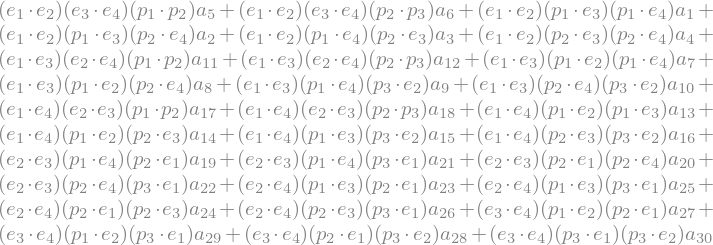

In [13]:
n = 4

# generate sympy symbols for kinematics
Generate_Symbols_kinematics_gluon(n)

# generate possible ansatz terms
ansatz_array_1234_gluon = Generate_ansatz_n_gluon(n,n-2)

print(ansatz_array_1234_gluon)

# generate ansatz
n1234_gluon_ansatz, four_gluon_term_list = Generate_ansatz(ansatz_array_1234_gluon,n,include_term_list=True)
n1234_gluon_ansatz

# number of terms for specific channel
# len(n1234_gluon_ansatz.subs(p2p3,0).args)

First we will constrain this by using one of the isomorphism of the topology. For this we use the antisymmetry of switching two legs, e.g. $n(1234) = -n(2134)$. We will also change the process of solving the equations slightly. Due to the large number of variables and lack of distinction between types of variables (e.g. a2 or a p1p3 term) the solver can not directly find a solution of everything simultaneously. Instead, we loop over the kinematic component (i.e. ignoring the prefactors) of all possible ansatz terms and collect all relations of prefactors. The result will be a list of only relations between prefactors which can be solved simultaneously by the Sympy solve function. For future use, I made a "solve prefactors" function that takes the equation to solve and possible terms as input and returns a dictionary of constraints that can be substituted directly.

In [14]:
def Solve_prefactors(expression, possible_terms):
    """give expression that equals zero and all possible terms, return dict of constrains"""
    coeffs = [expression.coeff(vi) for vi in possible_terms]
    # print(coeffs)
    # print(len(coeffs))
    # print(solve(coeffs[:40],dict=True))
    return solve(coeffs,dict=True)[0]

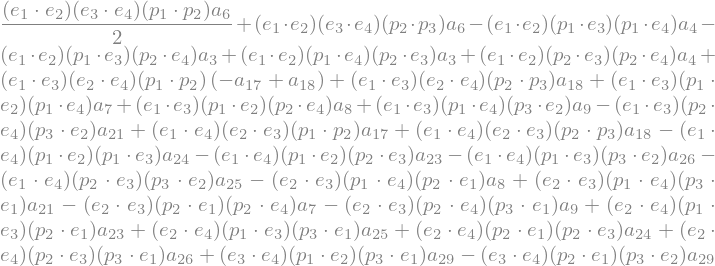

In [15]:
n2134_gluon_ansatz = Eliminate_mom_massless(Generate_ansatz(Index_swap_ansatz(ansatz_array_1234_gluon,[[1,2]]),n),n).expand()
gluon_sym_const_1_4pt = Solve_prefactors(n2134_gluon_ansatz+n1234_gluon_ansatz,four_gluon_term_list)

n1234_gluon_ansatz_const_1 = n1234_gluon_ansatz.subs(gluon_sym_const_1_4pt)
n1234_gluon_ansatz_const_1

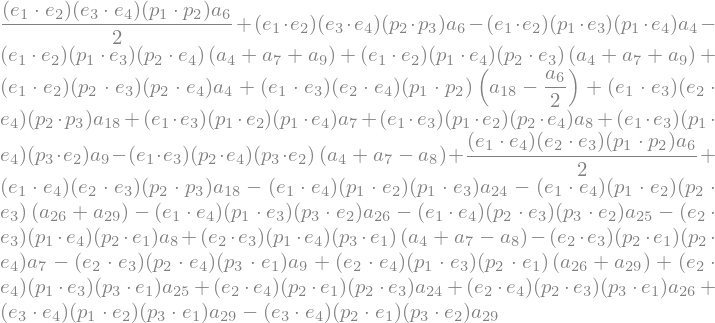

In [16]:
n2314_gluon_ansatz_const_1 = Eliminate_mom_massless(Generate_ansatz(Index_swap_ansatz(ansatz_array_1234_gluon,[[1,2],[1,3]]),n),n).expand().subs(gluon_sym_const_1_4pt)
n3124_gluon_ansatz_const_1 = Eliminate_mom_massless(Generate_ansatz(Index_swap_ansatz(ansatz_array_1234_gluon,[[1,2],[2,3]]),n),n).expand().subs(gluon_sym_const_1_4pt)

gluon_jacobi_const_4pt = Solve_prefactors(n1234_gluon_ansatz_const_1 + n2314_gluon_ansatz_const_1 + n3124_gluon_ansatz_const_1,four_gluon_term_list)

n1234_gluon_ansatz_const_2 = n1234_gluon_ansatz_const_1.subs(gluon_jacobi_const_4pt)
n1234_gluon_ansatz_const_2

This has constrained the ansatz significantly already! Next up we will use the fact that the amplitude should be gauge invariant to further constrain the amplitude. To do this, we construct a colour order amplitude. This is done by calculating the numerators of the appropriate channels. For example, $A(1234) = \frac{n_s}{2(p_1\cdot p_2)} + \frac{n_u}{2(p_2\cdot p_3)}$, where $n_u(1234) = n_s - n_t = n_s(1234) - n_s(1324)$. 

Gauge invariance can be checked by replacing one of the polarizations with its corresponding momentum, let us say $\epsilon_3 \to p_3$. A physical amplitude should vanish after doing this transformation. Down below we find a function that takes care of replacing each polarization with the corresponding momentum. Additionally, as we don not like to deal with fraction, we will multiply the amplitude with a product of the two propagators. As this changes the ansatz we need to find the terms that need to be considered to constrain the parameters, there is also a function for this.

In [17]:
def Gauge_transform(amplitude, transform_index, n, massless = True):
    """
    replace terms in line with a gauge transform of the form e_i -> p_i, after which the amplitude should vanish. (as e_i -> e_i + p_i is invariant)
    """
    
    # find the terms that contain the polarization that needs to be transformed
    transform_list = []
    for terms in amplitude.args:
        for termcomponent in terms.args:
            # print()
            # print(termcomponent)
            if len(str(termcomponent)) > 1:
                if str(termcomponent)[1] == 'e' or str(termcomponent)[1] == 'p':
                    if str(termcomponent)[1] == 'e' and str(termcomponent)[4] == str(transform_index):
                        transform_list.append(termcomponent)
                    elif str(termcomponent)[12] == 'e' and str(termcomponent)[15] == str(transform_index):
                        transform_list.append(termcomponent)

    # remove duplicates
    unique_transform_list = list(dict.fromkeys(transform_list))

    # substitute the new terms into the amplitude
    for unique_term in unique_transform_list:
        if str(unique_term)[1] == 'e' and str(unique_term)[4] == str(transform_index):
            amplitude = amplitude.subs(unique_term, globals()['p'+str(transform_index)+'e'+str(unique_term)[15]])
            # print('p'+str(transform_index)+'e'+str(unique_term)[15])
        elif str(unique_term)[1] == 'p' and str(unique_term)[4]<str(transform_index):
            amplitude = amplitude.subs(unique_term, globals()['p'+str(unique_term)[4]+'p'+str(transform_index)])
            # print('p'+str(unique_term)[4]+'p'+str(transform_index))
        elif str(unique_term)[1] == 'p' and str(unique_term)[4]>str(transform_index):
            amplitude = amplitude.subs(unique_term, globals()['p'+str(transform_index)+'p'+str(unique_term)[4]])
            # print('p'+str(transform_index)+'p'+str(unique_term)[4])
        else:
            amplitude = amplitude.subs(unique_term,globals()['p'+str(transform_index)+'e'+str(unique_term)[4]])
            # print('p'+str(transform_index)+'e'+str(unique_term)[4])
    if massless == True:
        return Eliminate_mom_massless(amplitude,n).expand()
    else:
        return Eliminate_mom_massive(amplitude,n).expand()

def Term_list_generator(ansatz_terms):
    """
    Generate a complete and uniquelist of terms that occur in the ansatz
    """
    result_list = []
    for terms in ansatz_terms.args:
        tempres = 1
        for termcomponent in terms.args:
            if len(str(termcomponent)) > 1:
                if str(termcomponent)[1] == 'e' or str(termcomponent)[1] == 'p':
                    tempres *= termcomponent
        result_list.append(tempres)
    
    return list(dict.fromkeys(result_list))

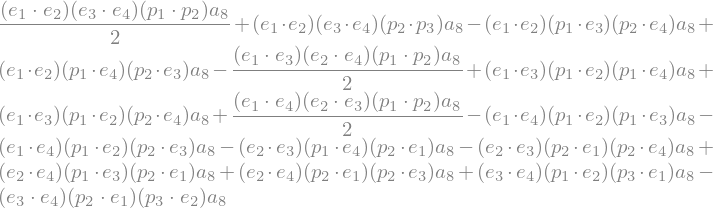

In [18]:
# with jacobi's (turns out the jacobis are not needed to constrian this amplitude)

# generate n1324 to construct the u-channel
n1324_gluon_ansatz_const_2 = Eliminate_mom_massless(Generate_ansatz(Index_swap_ansatz(ansatz_array_1234_gluon,[[2,3]]),n).subs(gluon_sym_const_1_4pt).subs(gluon_jacobi_const_4pt),n).expand()

# find u channel numerator
n1234_gluon_ansatz_u_channel_const_2 = n1234_gluon_ansatz_const_2 - n1324_gluon_ansatz_const_2

# find color ordered amplitude
A1234_gluon_ansatz_const_2 = (n1234_gluon_ansatz_const_1/(2*p1p2) + n1234_gluon_ansatz_u_channel_const_2/(2*p2p3)).expand()

# do the gauge transform e3 -> p3, this should make the amplitude vanish
A1234_gluon_ansatz_transformed = (Gauge_transform(A1234_gluon_ansatz_const_2,3,n)*p1p2*p2p3).expand()

# solve for the prefactors that make this amplitude vanish
gluon_gauge_const_4pt = Solve_prefactors(A1234_gluon_ansatz_transformed,Term_list_generator(A1234_gluon_ansatz_transformed))


# constrain the numerator with the resulting constrains
n1234_gluon_ansatz_const_3 = n1234_gluon_ansatz_const_2.subs(gluon_gauge_const_4pt)
n1234_gluon_ansatz_const_3

We notice there is one common prefactor left, as before, this can be set to the appropriate coupling constant. We could also fix it by considering a factorization channel. If we make a cut on the propagator, the 4 point amplitude should split into two 3 point amplitudes which have the coupling already incorporated. Though we have set this to 1 previously but could be reinstated appropriately. In any case, it is a good check to see if the 4 point amplitude factorizes properly. 

To do this I wrote a function to properly match internal kinematics and contract the correct terms. This is found below

In [19]:
def Factorization_cross_terms(expression, fact_index):
    """ Given an expression of an amplitude/numerators and which of the indices correpsond to the internal leg, return the terms that contain this internal leg and the terms that need to be contracted with another term"""
    expr_list = []
    build_list = []
    if expression.args == ():
        expression_iterable = [expression]
    else:
        expression_iterable = expression.args
    for nterm in expression_iterable:
        if nterm.args == ():
            if nterm != -1:
                nterm_arg = nterm
                if ((int(str(nterm_arg)[4]) == fact_index)*(str(nterm_arg)[1] == 'e')) or ((int(str(nterm_arg)[15]) == fact_index)*(str(nterm_arg)[12] == 'e')):
                    expr_list.append(nterm_arg)
                    if int(str(nterm_arg)[4]) == fact_index:
                        build_list.append(str(nterm_arg)[12]+str(nterm_arg)[15])
                    else:
                        build_list.append(str(nterm_arg)[1]+str(nterm_arg)[4])
        else: 
            for nterm_arg in nterm.args:
                # old:
                # if nterm_arg != -1:
                # new:
                if str(nterm_arg)[0] != '-' and str(nterm_arg)[0] != '1' and type(nterm_arg) != Integer:
                    if ((int(str(nterm_arg)[4]) == fact_index)*(str(nterm_arg)[1] == 'e')) or ((int(str(nterm_arg)[15]) == fact_index)*(str(nterm_arg)[12] == 'e')):
                        expr_list.append(nterm_arg)
                        if int(str(nterm_arg)[4]) == fact_index:
                            build_list.append(str(nterm_arg)[12]+str(nterm_arg)[15])
                        else:
                            build_list.append(str(nterm_arg)[1]+str(nterm_arg)[4])
    return expr_list, build_list

def Factorization_channel(numerator_L, numerator_R, fact_index_L, fact_index_R):
    """ given the numerator and the left and right hand side, return a dictionary of terms that need to be replaced by the new contration."""
    expr_list_L, build_list_L = Factorization_cross_terms(numerator_L,fact_index_L)
    expr_list_R, build_list_R = Factorization_cross_terms(numerator_R,fact_index_R)

    cross_terms = {}
    for i,L in enumerate(expr_list_L):
        for j,R in enumerate(expr_list_R):
            if build_list_L[i][0] == build_list_R[j][0]:
                if build_list_L[i][1] < build_list_R[j][1]:
                    cross_terms[L*R] = globals()[build_list_L[i]+build_list_R[j]]
                else:
                    cross_terms[L*R] = globals()[build_list_R[j]+build_list_L[i]]
            elif build_list_L[i][0] == 'p':
                cross_terms[L*R] = globals()[build_list_L[i]+build_list_R[j]]
            else:
                cross_terms[L*R] = globals()[build_list_R[j]+build_list_L[i]]
    return cross_terms

The way we do the factorization is as follows. First we decide to choose a certain factorization channel. Let us consider the s channel with propagator $s_{12}$. For this we will generate an amplitude containing external gluons with index 1 and 2 plus one additional arbitrary index (lets say 3), and we generate one with external gluons with index 3 and 4 plus an arbitrary fourth (lets say 1). As we need to sum over states of the internal polarization we will have to contract every index "3" and "1" of the two amplitudes respectively. We can then simply multiply these two amplitudes and substitute the "cross terms" due to the sum over states.

{a_8: -1}


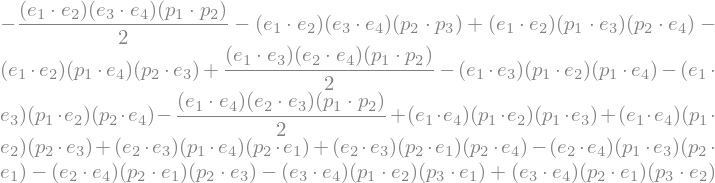

In [20]:
# we use n123_gluon from before but we also need to generate n134_gluon
n134_gluon = Generate_ansatz(Index_swap_ansatz(ansatz_array_123_gluon,[[1,3],[2,4]]),3).subs(symmetry_constraint_1_3pt).subs(symmetry_constraint_2_3pt).subs(a3,1)

# multiply the numerators/amplitudes (in the case of 3 point amplitudes they are the same up to coupling constants and normalization but this can be safely ignored). As the amplitudes are on shell we need to have p1p2 = 0
A3A3_s_channel = Eliminate_mom_massless((n123_gluon*n134_gluon).expand().subs(Factorization_channel(n123_gluon,n134_gluon,3,1)),n).expand().subs(p1p2,0) 
A3A3_s_channel

gluon_fact_s_4pt = Solve_prefactors(n1234_gluon_ansatz_const_3.subs(p1p2,0)-A3A3_s_channel,four_gluon_term_list)
print(gluon_fact_s_4pt)

n1234_gluon_ansatz_const_4 = n1234_gluon_ansatz_const_3.subs(gluon_fact_s_4pt)
n1234_gluon_ansatz_const_4

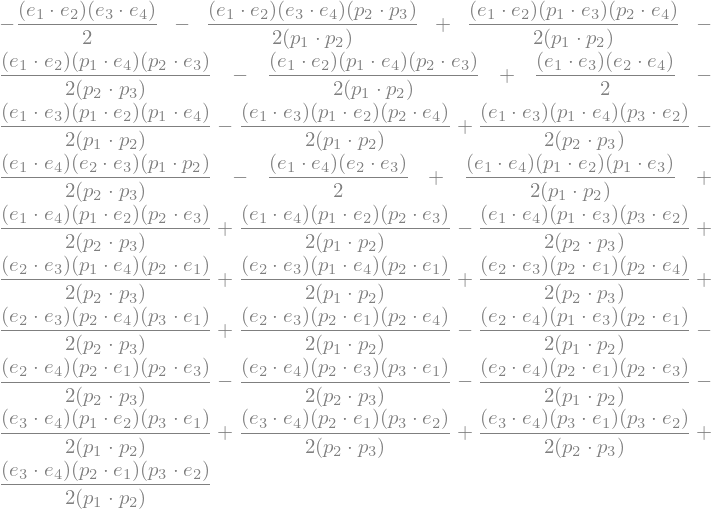

In [21]:
A1234_gluon = A1234_gluon_ansatz_const_2.subs(gluon_gauge_const_4pt).subs(gluon_fact_s_4pt)
A1234_gluon

The last free parameter is indeed fixed using this factorization channel showing that it does factorize into two 3 point amplitudes. The same could be done for other channels but is not necessary to constrain the ansatz.

This concludes the section of pure Yang-Mills amplitudes. We could go further to higher point amplitudes, but for now this is all we need. This brings us to the next section.

# 2 Massive scalars and n-2 gluons in Yang-Mills

In this section we will consider amplitudes including heavy scalars. We will again start at 3 point and build our way up to 5 point. There are some subtleties to each of these steps. First we need a slightly different set of symbols, to be sure we have everything we will have to run this first for each multiplicity. The function to generate the ansatz terms is also slightly different for this reason. The function for rewriting terms is also slightly different for amplitudes that include two massive particles. The functions are defined below.

In [22]:
def Generate_Symbols_kinematics(n):
    """Generate kinematic objects for scalar qcd calculations with n-2 gluons and and 2 heavy scalars. particle 1 and n are the heavy scalars. 
    Only generate objects that are generally non zero on shell (so no pi dot epsi for example)"""
    
    # lists for e, p variable and symbol names
    p_list = list(map(str,range(1,n+1)))
    eps_list = p_list[1:-1]


    variable_list = ['ee']*(np.arange(n-2)).sum() + ['pp']*(np.arange(n)).sum() + ['pe']*((n-2)*(n-1)) + ['s']*np.arange(n-2).sum() + ['ve']*(n-2)+ ['vp']*(n-2)+ ['ke']*(n-2)+ ['kp']*(n-2)+ ['pp']*(n)
    symbol_name_list = ['(e_{}\cdot\ e_{})']*(np.arange(n-2)).sum() + ['(p_{}\cdot\ p_{})']*(np.arange(n)).sum() + ['(p_{}\cdot\ e_{})']*((n-2)*(n-1)) + ['s_{}']*np.arange(n-2).sum() + ['(v\cdot\ e_{})']*(n-2)+ ['(v\cdot\ p_{})']*(n-2)+ ['(k\cdot\ e_{})']*(n-2)+ ['(k\cdot\ p_{})']*(n-2)+ ['(p_{}\cdot\ p_{})']*(n)

    iterator = 0

    # generate e dot e's
    for i in eps_list[:-1]:
        for k in eps_list[int(i)-1:]:
            symbol_name_list[iterator] = symbol_name_list[iterator].format('{'+eps_list[int(i)-2]+'}','{'+eps_list[int(k)-2]+'}')
            variable_list[iterator] = variable_list[iterator][0] + str(eps_list[int(i)-2]+variable_list[iterator][1]+eps_list[int(k)-2])
            iterator += 1

    # generate p dot p's
    for i in p_list:
        for k in p_list[int(i):]:
            symbol_name_list[iterator] = symbol_name_list[iterator].format('{'+p_list[int(i)-1]+'}','{'+p_list[int(k)-1]+'}')
            variable_list[iterator] = variable_list[iterator][0] + str(p_list[int(i)-1]+variable_list[iterator][1]+p_list[int(k)-1])

            iterator += 1

    # geneerate p dot e's
    for k in eps_list:
        for i in p_list:
            if eps_list[int(k)-2]!=p_list[int(i)-1]:
                symbol_name_list[iterator] = symbol_name_list[iterator].format('{'+p_list[int(i)-1]+'}','{'+eps_list[int(k)-2]+'}')
                variable_list[iterator] = variable_list[iterator][0] + str(p_list[int(i)-1]+variable_list[iterator][1]+eps_list[int(k)-2])

                iterator += 1

    # generate s'
    for i in eps_list[:-1]:
        for k in eps_list[int(i)-1:]:
            symbol_name_list[iterator] = symbol_name_list[iterator].format("".join(eps_list[int(i)-2:int(k)-1]))
            variable_list[iterator] += "".join(eps_list[int(i)-2:int(k)-1])
            iterator += 1

    # generate e dot v's for expressing the mass of the massive particles seperatly
    for i in eps_list:
        symbol_name_list[iterator] = symbol_name_list[iterator].format('{'+i+'}')
        variable_list[iterator] += "".join(i)
        iterator += 1
        
    # generate p dot v's for expressing the mass of the massive particles seperatly
    for i in eps_list:
        symbol_name_list[iterator] = symbol_name_list[iterator].format('{'+i+'}')
        variable_list[iterator] += "".join(i)
        iterator += 1
        
    # generate e dot k's for expressing the mass of the massive particles seperatly
    for i in eps_list:
        symbol_name_list[iterator] = symbol_name_list[iterator].format('{'+i+'}')
        variable_list[iterator] += "".join(i)
        iterator += 1
        
    # generate p dot k's for expressing the mass of the massive particles seperatly
    for i in eps_list:
        symbol_name_list[iterator] = symbol_name_list[iterator].format('{'+i+'}')
        variable_list[iterator] += "".join(i)
        iterator += 1
        
    for i in p_list:
        symbol_name_list[iterator] = symbol_name_list[iterator].format('{'+p_list[int(i)-1]+'}','{'+p_list[int(i)-1]+'}')
        variable_list[iterator] = variable_list[iterator][0] + str(p_list[int(i)-1]+variable_list[iterator][1]+p_list[int(i)-1])
        iterator += 1
        
    print(variable_list)
    # generate sympy sympols for lack of better way we do it in a for loop
    for i,var in enumerate(variable_list):
        globals()[var] = symbols(symbol_name_list[i])

def Generate_ansatz_2_scalar_nmin2_gluon(n, powercount, HEFT=False):
    """Generate ansatz terms for n-2 gluon scattering and 2 massive particles with certain powercounting of the topology"""
    
    # number of gluons
    n_g = n-2
    # arrays which signals which terms are allowed to be generated
    ep_array = np.concatenate((np.ones((1,n_g)),np.ones((n_g,n_g))-np.eye(n_g)),axis=0)
    ee_array = np.triu(np.ones((n_g,n_g)),1)
    combined_array = np.concatenate((ee_array,ep_array),axis=0)

    # empty ansatz term list
    ansatz_terms = []

    for _ in range(100000):
        # empty ansatz term string
        ansatz_option = ''
        
        pol_counter = 0
        
        # make list of all non zero elements, e.g. possible options to start building an ansatz from
        iterable_options = np.array(np.nonzero(combined_array))
        # print(combined_array)

        # check if we still have options to iterate over
        if (iterable_options.any() == 0):
            # break if there are no possible staring points left
            break
        
        if (combined_array[n_g:,:].sum(axis=0).prod()) == 0:
            # break of the remaining terms cannot satisfy the condition that each term must have each polarization once.
            break
        
        # start building ansatz term by adding first part
        ansatz_option += Ans_pol_term_massive(iterable_options[:,0],n_g)

        if iterable_options[0,0] > n_g-1:
            pol_counter += 1
        else:
            pol_counter += 2    
            
        # set current element to start from to zero so that it cannot be used again
        combined_array[iterable_options[:,0][0],iterable_options[:,0][1]] = 0
        
        # create a copy of combined array to check wheter a term is used already or not
        generator_array = np.copy(combined_array)

        # now set all rows and colums that have the polarization of the first part of the ansatz to zero as we can only have each polirization once
        if iterable_options[:,0][0] < n_g:
            generator_array[iterable_options[:,0][0],:] = 0
            generator_array[iterable_options[:,0][1],:] = 0
            generator_array[:,iterable_options[:,0][0]] = 0
            generator_array[:,iterable_options[:,0][1]] = 0
        else:
            generator_array[iterable_options[:,0][1],:] = 0
            generator_array[:,iterable_options[:,0][1]] = 0

        
        temp_ansatz_list = []
        # now loop over all possible options to build the ansatz term and build it in a similar fasion as the previous part blocking terms that have been used already
        pos_ee_terms, pol_power_ee = get_possible_ee_terms(generator_array,n_g)
        for i in range(len(pos_ee_terms)):
            temp_ansatz = ''
            for j in range(len(pos_ee_terms[i])):
                temp_ansatz += ' '+Ans_pol_term_massive(pos_ee_terms[i][j],n_g)
            temp_ansatz_list.append(ansatz_option+temp_ansatz)
        pol_power_ee = np.array(pol_power_ee)+pol_counter
        
        for i in range(len(temp_ansatz_list)):

            if pol_power_ee[i] == n_g:
                ansatz_terms.append(temp_ansatz_list[i])

            else:
                ep_gen_array = np.copy(generator_array)
                for pol_constrain in pos_ee_terms[i]:
                    ep_gen_array[:,pol_constrain[0]] = 0
                    ep_gen_array[:,pol_constrain[1]] = 0
                    
                pos_ep_terms = get_possible_ep_terms(ep_gen_array,n_g,massive=True)
                [ansatz_terms.append(temp_ansatz_list[i]+' '+s) for s in pos_ep_terms]
        
    # Add mandelstam terms
    pp_array = np.triu(np.ones((n-1,n-1)),1)
    pp_array[0,-1] = 0
    pp_array[0,0] = 1
    final_ansatz_terms = []

    # check the powercounting of each term to see if we need to add a component of a term that contains mandelstams.
    for ansatz_iter in ansatz_terms:
        if ansatz_iter.count('p') < powercount:
            # generate mandelstam terms
            mandelstam_terms = Ans_mandelstam_term(np.array(np.nonzero(pp_array)).T,(int((powercount-ansatz_iter.count('p'))/2)-1))
            for mandelstam_iter in mandelstam_terms:
                final_ansatz_terms.append(ansatz_iter +' '+ mandelstam_iter)
                if (HEFT == True)*(final_ansatz_terms[-1].count('p1') == 0):
                    # as all lower mass terms except the m^0 term are needed to construct the amplitudes at for HEFT we need to remove the later and keep all others
                    final_ansatz_terms.pop(-1)

        elif ansatz_iter.count('p') == powercount:
            final_ansatz_terms.append(ansatz_iter)
            if (HEFT == True)*(final_ansatz_terms[-1].count('p1') == 0):
                # as all lower mass terms except the m^0 term are needed to construct the amplitudes at for HEFT we need to remove the later and keep all others
                final_ansatz_terms.pop(-1)
    return final_ansatz_terms

def Eliminate_mom_massive(ansatz,n):
    mom_eps_range = range(2,n)
    rep_mom_range = range(1,n)
    sub_term_mom = -globals()['p1p2'] 
    
    # find term that can be eliminated due to (pn)^2 = m^2, subsituting pn = p1 + p2 + ... pn-1
    for i in rep_mom_range[:-1]:
        for j in range(i+1,n):
            if (i==1)*(j==n-1):
                break
            elif not (i==1)*(j==2):
                sub_term_mom += -globals()['p'+str(i)+'p'+str(j)]
    # here we simply find the term that can be liminated by substituting pn = p1 + p2 + ... pn-1 for the pipi and piei terms
    for i in mom_eps_range:
        sub_term = -globals()['p1p'+str(i)]
        sub_term2 = -globals()['p1e'+str(i)]
        for j in rep_mom_range[1:]:
            if j < i:
                sub_term += -globals()['p'+str(j)+'p'+str(i)]
                sub_term2 += -globals()['p'+str(j)+'e'+str(i)]
            elif j > i: 
                sub_term += -globals()['p'+str(i)+'p'+str(j)]
                sub_term2 += -globals()['p'+str(j)+'e'+str(i)]       
        ansatz = ansatz.subs(globals()['p'+str(i)+'p'+str(n)],sub_term).subs(globals()['p'+str(n)+'e'+str(i)],sub_term2).subs(globals()['p1p'+str(n-1)],sub_term_mom)
    return ansatz

### 2 massive scalars 1 gluon in Yang-Mills (3pt)

The procedure is more or less the same as for just gluons, but there is just one term in the ansatz:

In [23]:
n = 3

# generate sympy symbols for kinematics
Generate_Symbols_kinematics(n)

# generate possible ansatz terms
ansatz_array_123 = Generate_ansatz_2_scalar_nmin2_gluon(n,n-2)
print(ansatz_array_123)

# generate ansatz
n123_ansatz = Generate_ansatz(ansatz_array_123,n)
n123 = n123_ansatz.subs(a1,1)
n123

['p1p2', 'p1p3', 'p2p3', 'p1e2', 'p3e2', 've2', 'vp2', 'ke2', 'kp2', 'p1p1', 'p2p2', 'p3p3']
['p1e2']


As before we can simply fix the free parameter to the coupling constant which we for simplicity of calculations just set to 1

### 2 massive scalars 2 gluons in Yang-Mills (4pt)

Here we have two distinct topologies to consider. One with a massive and a massless propagator which we denote with m and ml respectively. We will first generate both of the topologies, so we can work with it from there. 

['e2e3', 'p1p2', 'p1p3', 'p1p4', 'p2p3', 'p2p4', 'p3p4', 'p1e2', 'p3e2', 'p4e2', 'p1e3', 'p2e3', 'p4e3', 's23', 've2', 've3', 'vp2', 'vp3', 'ke2', 'ke3', 'kp2', 'kp3', 'p1p1', 'p2p2', 'p3p3', 'p4p4']
['e2e3 p1p1', 'e2e3 p1p2', 'e2e3 p2p3', 'p1e2 p1e3', 'p1e2 p2e3', 'p1e3 p3e2', 'p2e3 p3e2']


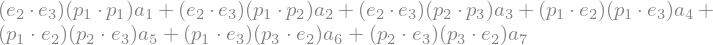

In [24]:
n = 4 

# generate sympy symbols for kinematics
Generate_Symbols_kinematics(n)

#generate possible ansatz terms
ansatz_array_1234 = Generate_ansatz_2_scalar_nmin2_gluon(n,n-2)
print(ansatz_array_1234)

#generate ansatz
nm1234_ansatz, four_2m2g_term_list = Generate_ansatz(ansatz_array_1234,n,include_term_list=True)

# genereate ansatz for n1324 to calculate the other channel
nm1324_ansatz = Eliminate_mom_massive(Generate_ansatz(Index_swap_ansatz(ansatz_array_1234,[[2,3]]),n),n).expand()

# defintion of the massless channel
nml1234_ansatz = nm1234_ansatz - nm1324_ansatz

# show ansatz of massive propagator topology
nm1234_ansatz


There are again multiple ways to constrain the amplitudes. We start with the constraints due to the isomorphism of the massive topology: $n(1234) = n(4321)$.

{a_4: a_5 + a_6}


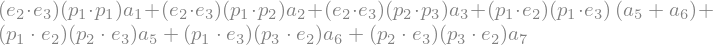

In [25]:
# generate the isomorphism
nm4321_ansatz = Eliminate_mom_massive(Generate_ansatz(Index_swap_ansatz(ansatz_array_1234,[[2,3],[1,4]]),n),n).expand()

# find constraints
massive_sym_const_1_4pt = Solve_prefactors(nm1234_ansatz-nm4321_ansatz,four_2m2g_term_list)
print(massive_sym_const_1_4pt)

# apply constraints
nm1234_ansatz_const_1 = nm1234_ansatz.subs(massive_sym_const_1_4pt)
nml1234_ansatz_const_1 = nml1234_ansatz.subs(massive_sym_const_1_4pt)

# show constrained ansatz
nm1234_ansatz_const_1

Thus, the first constraint is $a_4 = a_5 + a_6$. Next we will consider, as before, gauge invariance. 

{a_2: -a_5/2, a_3: -a_7, a_6: 0, a_1: 0}


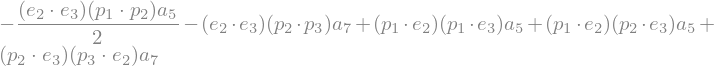

In [26]:
# calculate the color ordered amplitude 
A1234_ansatz_const_1 = (nm1234_ansatz_const_1/(2*p1p2) + nml1234_ansatz_const_1/(2*p2p3)).expand()

# transform the amplitude, again with e3 -> p3
A1234_ansatz_transformed = (Gauge_transform(A1234_ansatz_const_1,3,n,massless=False)*p1p2*p2p3).expand()

# solve for vanishing amplitude
massive_gauge_const_4pt = Solve_prefactors(A1234_ansatz_transformed,Term_list_generator(A1234_ansatz_transformed))
print(massive_gauge_const_4pt)


nm1234_ansatz_const_2 = nm1234_ansatz_const_1.subs(massive_gauge_const_4pt)
nml1234_ansatz_const_2 = nml1234_ansatz_const_1.subs(massive_gauge_const_4pt)
A1234_ansatz_const_2 = A1234_ansatz_const_1.subs(massive_gauge_const_4pt)

nm1234_ansatz_const_2

We have two possible cuts we can perform factorization on. We will focus on the one where we need to cut the massive propagator. This is slightly simpler as we do not have to deal with a sum over states of an internal gluon. For this we need two on shell 2 massive, one gluon 3pt amplitudes. This is simple to construct as there is only one term to consider with a single momenta for each amplitude. The incoming momenta for the first A3L amplitude is just $p_1$. For the other, A3R, the incoming momentum is the internal propagator, which, on shell, is the sum $(p_1 + p_2)$. Each with their corresponding polarization results in:

{a_7: 0, a_5: 1}


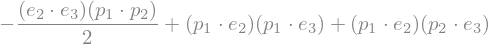

In [27]:
A3L = n123 
A3R = n123.subs(p1e2,p1e3+p2e3)
A4_cut_s12 = nm1234_ansatz_const_2/(2*p1p2)
massive_fact_const_4pt = Solve_prefactors((A4_cut_s12*(2*p1p2)).subs(p1p2,0)-(A3L*A3R).expand(),four_2m2g_term_list)
print(massive_fact_const_4pt)
nm1234 = nm1234_ansatz_const_2.subs(massive_fact_const_4pt)
nml1234 = nml1234_ansatz_const_2.subs(massive_fact_const_4pt)


# show the final amplitude
nm1234

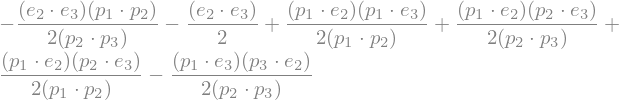

In [28]:
A1234 = A1234_ansatz_const_2.subs(massive_fact_const_4pt)
A1234

This fully constrains the amplitude. Factorization of the second channel is not necessary to fix all the parameters. 

##### HEFT expansion of 2 massive scalar 2 gluon amplitude.

We will now do a heft expansion of this result. Keep highest mass scaling (consider $p_1$ and $p_n$) which leaves us with:

In [29]:
def Leading_order_HEFT_extractor(expression):
    """extracts leading term from mass expansion for HEFT amplitudes"""
    leading_term = 0
    order = 0
    for term in expression.args:
        numerator, denominator = fraction(term)
        if diff(denominator,p1p2) == 0 and diff(denominator,p1p3) == 0:
            term_order = str(numerator).count('p_{1}')
        elif diff(denominator,p1p2,2) == 0:
            term_order = str(numerator).count('p_{1}') - 1
        else:
            term_order = str(numerator).count('p_{1}') - 2

        if term_order == order:
            leading_term += term
        elif term_order > order:
            leading_term = term
            order = term_order
    return leading_term

def Termwise_Mandelstam_Substitution(expression):
    """Cancel terms in an expression term by term"""
    new_expression = 0
    for term in expression.args:
        numerator = term.as_numer_denom()[0]
        numerator = numerator.subs(p2p3,s23/2).subs(p3p4,s34/2).subs(p2p4,s24/2)
        denominator = term.as_numer_denom()[1]
        denominator = denominator.factor().subs((p2p3+p2p4+p3p4),s234/2).subs((p1p2+p1p3+p2p3),(s123-m**2)/2).subs(p1p2,(s12-m**2)/2).subs(p2p3,s23/2).subs(p3p4,s34/2)
        new_expression += numerator/denominator.factor()
    return new_expression

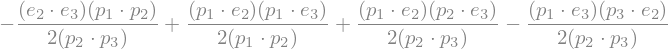

In [30]:
Leading_order_HEFT_extractor(A1234)

This is the correct HEFT expression. We would like to write this in terms of mandelstams, for this we can use another function.

In [31]:
def Termwise_Mandelstam_Substitution(expression):
    """Cancel terms in an expression term by term"""
    # define these for the subsitutions, this function is not generalized for higher point amplitudes and only works up to five point
    s12 ,s13, s24, s123, s234, m = symbols('s_{12} s_{13} s_{24} s_{123} s_{234} m')

    new_expression = 0
    for term in expression.args:
        numerator = term.as_numer_denom()[0]
        numerator = numerator.subs(p2p3,s23/2).subs(p3p4,s34/2).subs(p2p4,s24/2)
        denominator = term.as_numer_denom()[1]
        denominator = denominator.factor().subs((p2p3+p2p4+p3p4),s234/2).subs((p1p2+p1p3+p2p3),(s123-m**2)/2).subs(p1p2,(s12-m**2)/2).subs(p2p3,s23/2).subs(p3p4,s34/2)
        new_expression += numerator/denominator.factor()
    return new_expression

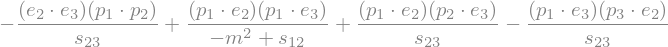

In [32]:
(Termwise_Mandelstam_Substitution(Leading_order_HEFT_extractor(A1234)))

Terms involving p1 in the numerator are not substituted to highlight the dependence on massive momenta in the amplitudes

This is the correct HEFT amplitude

### 2 scalar 3 gluon amplitude (5pt)

Generate ansatz and all different components needed for a color ordered amplitude

In [33]:
n = 5

# generate sympy symbols for kinematics
Generate_Symbols_kinematics(n)

#generate possible ansatz terms
ansatz_array_12345 = Generate_ansatz_2_scalar_nmin2_gluon(n,n-2)

#generate ansatz
nmm12345_ansatz, five_2m3g_term_list = Generate_ansatz(ansatz_array_12345,n,include_term_list=True)
print("Number of terms in ansatz:",len(nmm12345_ansatz.args))


['e2e3', 'e2e4', 'e3e4', 'p1p2', 'p1p3', 'p1p4', 'p1p5', 'p2p3', 'p2p4', 'p2p5', 'p3p4', 'p3p5', 'p4p5', 'p1e2', 'p3e2', 'p4e2', 'p5e2', 'p1e3', 'p2e3', 'p4e3', 'p5e3', 'p1e4', 'p2e4', 'p3e4', 'p5e4', 's23', 's234', 's34', 've2', 've3', 've4', 'vp2', 'vp3', 'vp4', 'ke2', 'ke3', 'ke4', 'kp2', 'kp3', 'kp4', 'p1p1', 'p2p2', 'p3p3', 'p4p4', 'p5p5']
Number of terms in ansatz: 81


In [34]:
nmm12435_ansatz = Eliminate_mom_massive(Generate_ansatz(Index_swap_ansatz(ansatz_array_12345,[[3,4]]),n),n).expand()
nmm52341_ansatz = Eliminate_mom_massive(Generate_ansatz(Index_swap_ansatz(ansatz_array_12345,[[1,5]]),n),n).expand()
nmm52431_ansatz = Eliminate_mom_massive(Generate_ansatz(Index_swap_ansatz(ansatz_array_12345,[[1,5],[3,4]]),n),n).expand()
nmm54321_ansatz = Eliminate_mom_massive(Generate_ansatz(Index_swap_ansatz(ansatz_array_12345,[[1,5],[2,4]]),n),n).expand()
nmm54231_ansatz = Eliminate_mom_massive(Generate_ansatz(Index_swap_ansatz(ansatz_array_12345,[[1,5],[2,3],[3,4]]),n),n).expand()
nmm14325_ansatz = Eliminate_mom_massive(Generate_ansatz(Index_swap_ansatz(ansatz_array_12345,[[2,4]]),n),n).expand()
nmm14235_ansatz = Eliminate_mom_massive(Generate_ansatz(Index_swap_ansatz(ansatz_array_12345,[[2,3],[3,4]]),n),n).expand()

nmml12345_ansatz = nmm12345_ansatz - nmm12435_ansatz
nmml52341_ansatz = nmm52341_ansatz - nmm52431_ansatz
nmml54321_ansatz = nmm54321_ansatz - nmm54231_ansatz
nmml14325_ansatz = nmm14325_ansatz - nmm14235_ansatz

nmlml12345_ansatz = nmml12345_ansatz - nmml52341_ansatz
nmlml14325_ansatz = nmml14325_ansatz - nmml54321_ansatz


A12345_ansatz = (nmm12345_ansatz/(2*p1p2*(2*p1p2+2*p1p3+2*p2p3)) + nmml12345_ansatz/(2*p1p2*2*p3p4) + nmlml12345_ansatz/((2*p2p3+2*p2p4+2*p3p4)*2*p3p4) - nmml54321_ansatz/(2*p2p3*(2*p1p2+2*p1p3+2*p2p3))  + nmlml14325_ansatz/(2*p2p3*(2*p2p3+2*p2p4+2*p3p4))).expand()

The minus sign arises from the fact that the topology of nmml 54321 with the right color ordering changes with a minus sign. First we will use symmetry to constrain this amplitude using $n(12345) = -n(54321)$.

In [35]:
# generate the isomorphism
nmm54321_ansatz = Eliminate_mom_massive(Generate_ansatz(Index_swap_ansatz(ansatz_array_12345,[[2,4],[1,5]]),n),n).expand()

# find constraints
massive_sym_const_1_5pt = Solve_prefactors(nmm12345_ansatz+nmm54321_ansatz,five_2m3g_term_list)
# print(massive_sym_const_1_5pt)
print(len(massive_sym_const_1_5pt))

# apply constraints
nmm12345_ansatz_const_1 = nmm12345_ansatz.subs(massive_sym_const_1_5pt)
nmml12345_ansatz_const_1 = nmml12345_ansatz.subs(massive_sym_const_1_5pt)
nmlml12345_ansatz_const_1 = nmlml12345_ansatz.subs(massive_sym_const_1_5pt)
A12345_ansatz_const_1 = A12345_ansatz.subs(massive_sym_const_1_5pt)

38


Next we will use gauge invariance again.

In [36]:
A12345_ansatz_transformed = (Gauge_transform(A12345_ansatz_const_1,3,n,massless=False)*(2*p1p2)*(2*p1p2+2*p1p3+2*p2p3)*(2*p3p4)*(2*p2p3+2*p2p4+2*p3p4)*(2*p2p3)).expand().cancel()

massive_gauge_const_5pt = Solve_prefactors(A12345_ansatz_transformed,Term_list_generator(A12345_ansatz_transformed))
# print(massive_gauge_const_5pt)

nmm12345_ansatz_const_2 = nmm12345_ansatz_const_1.subs(massive_gauge_const_5pt)
nmml12345_ansatz_const_2 = nmml12345_ansatz_const_1.subs(massive_gauge_const_5pt)
nmlml12345_ansatz_const_2 = nmlml12345_ansatz_const_1.subs(massive_gauge_const_5pt)
A12345_ansatz_const_2 = A12345_ansatz_const_1.subs(massive_gauge_const_5pt)


We only have a few parameters left. We will have to constrain it further using factorization. The simplest cut we can do are double cuts splitting the amplitude into three 3 point amplitudes. The topology I will use for this double cut is the one related to the nmml12345 numerator. The cuts made will be at $s_{12}$ and $s_{34}$. The left-hand side will have the limit of both of these going to $m^2$ and 0 respectively with $A_5$ multiplied by the mandelstams. The right-hand side will be a product of three 3pt amplitudes, two of the 2 scalar 1 gluon type and one 3 gluon amplitude.

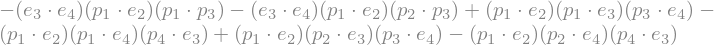

In [37]:
A3L = n123
A3R = n123
A3T = n134_gluon
# properly sum over the states, the left over "p1" index corresond to the internal momentum which is actually p1+p2 
A4R = (A3R*A3T).expand().subs(Factorization_channel(A3R,A3T,2,1)).subs(p1p3,p1p3+p2p3).subs(p1e3,p1e3+p2e3).subs(p1e4,p1e4+p2e4).expand()
A5_double_cut_s12_s34 = -(A3L*A4R).expand()
A5_double_cut_s12_s34

In [38]:
massive_fact_double_cut_s12_s34_5pt = Solve_prefactors(nmml12345_ansatz_const_2.subs(p1p2,0).subs(p3p4,0)-A5_double_cut_s12_s34,five_2m3g_term_list)
print(massive_fact_double_cut_s12_s34_5pt)

nmm12345_ansatz_const_3 = nmm12345_ansatz_const_2.subs(massive_fact_double_cut_s12_s34_5pt)
nmml12345_ansatz_const_3 = nmml12345_ansatz_const_2.subs(massive_fact_double_cut_s12_s34_5pt)
nmlml12345_ansatz_const_3 = nmlml12345_ansatz_const_2.subs(massive_fact_double_cut_s12_s34_5pt)
A12345_ansatz_const_3 = A12345_ansatz_const_2.subs(massive_fact_double_cut_s12_s34_5pt)

{a_76: 0, a_78: 0, a_60: 1}


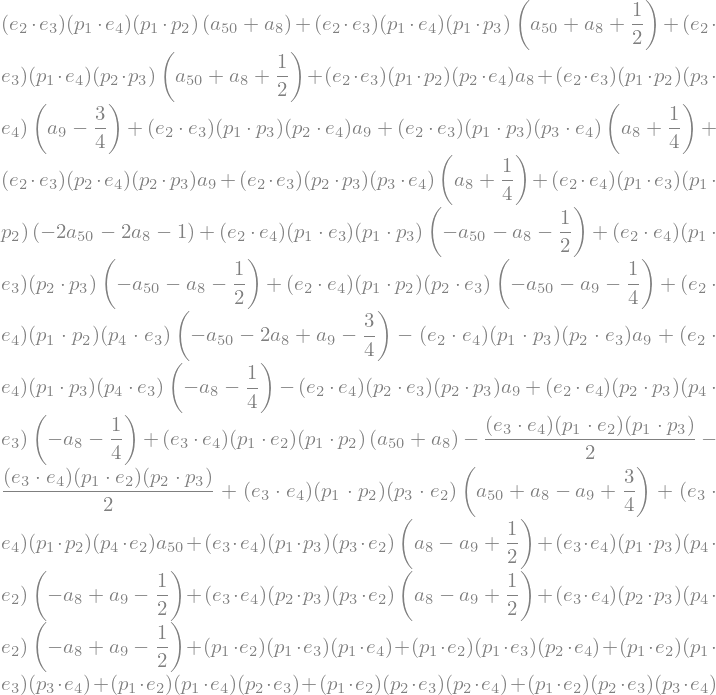

In [39]:
nmm12345_ansatz_const_3

When we look at the amplitude it turns out There are 3 free parameters left, however, if we write down the full amplitude, we see that they will all cancel. This means they are gauged parameters and do not matter for observables. Hence, the amplitude is fully constrained. To show it is correct, we will show factorization with a single cut for at least one channel:

In [40]:
# we need a function to .cancel() term by term:


def Termwise_cancel(expression):
    """Cancel terms in an expression term by term"""
    new_expression = 0
    for term in expression.args:
        new_expression += term.cancel()
    return new_expression

In [41]:
# find the two parts that make up the four point part of the factorization channel when cutting at s12
nm1345 = Generate_ansatz(Index_swap_ansatz(ansatz_array_1234,[[4,5],[3,4],[2,3]]),n).subs(massive_sym_const_1_4pt).subs(massive_gauge_const_4pt).subs(massive_fact_const_4pt)
nm1345
nmk345 = nm1345.subs(p1p3,p1p3+p2p3).subs(p1e3,p1e3+p2e3).subs(p1e4,p1e4+p2e4).expand()
nmk345

nm1435 = (Generate_ansatz(Index_swap_ansatz(ansatz_array_1234,[[4,5],[3,4],[2,3],[3,4]]),n).subs(massive_sym_const_1_4pt).subs(massive_gauge_const_4pt).subs(massive_fact_const_4pt)).expand()
nm1435

nml1345 = nm1345 - nm1435
nmlk345 = nml1345.subs(p1p3,p1p3+p2p3).subs(p1p4,p1p4+p2p4).subs(p1e3,p1e3+p2e3).subs(p1e4,p1e4+p2e4).expand()
nmlk345 = Eliminate_mom_massive(nmlk345,5).expand()
nmlk345

# A3L = n123
# # make this k345 with k = p1+p2
A4R = nmk345/(2*p1p2+2*p1p3+2*p2p3) + nmlk345/(2*p3p4)
A4R.subs(p1p2,0).expand()
# (((A3L*A4R).subs(p1p2,0)*2*p3p4*(2*p1p3+2*p2p3)))

# multiply by pole (s12), then we send that pole to zero. If we then take the part that has p1e2 (which is A3) and check whether what is left is A4 by substracting it and checking whether it is zero we know that, if the remained (whatever is not proportional to A3) is also zero, we know it factorizes correctly.
testfact = Termwise_cancel((A12345_ansatz_const_3*2*p1p2).expand()).subs(p1p2,0).coeff(p1e2)#.cancel()#.factor().expand()
testfact
A4R.subs(p1p2,0).expand()-testfact

Above we have only looked at the parts of the amplitude that are proportional to one of the factorization amplitudes A3. There are some terms remaining that are not proportional to this. If these terms do not cancel out, the amplitude does not factorize correctly. Hence, we need to see if the terms cancel:

In [42]:
((Termwise_cancel((A12345_ansatz_const_3*2*p1p2).expand()).subs(p1p2,0)-(Termwise_cancel((A12345_ansatz_const_3*2*p1p2).expand()).subs(p1p2,0).coeff(p1e2)*p1e2).expand())).cancel()

Somehow sympy does not like to rewrite the amplitude in a way that the form is kept and cancel all the gauge parameters. If we just make it cancel how it likes, the gauge parameters do drop out but the final amplitude is not in a very readable form. We can manually set the gauge parameters to zero as we are free to choose them. This might not be the simplest form of the amplitude however. The result is:

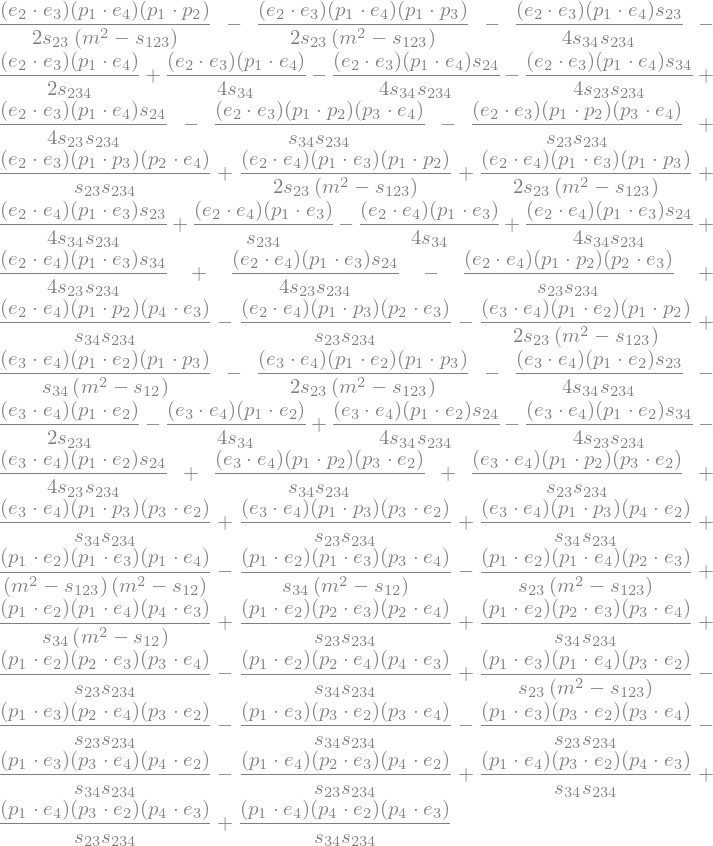

In [43]:
A12345_HEFT = Leading_order_HEFT_extractor(A12345_ansatz_const_3.subs(a8,0).subs(a9,0).subs(a50,0))#.coeff(p1e4)#.subs(a8,0).subs(a9,0).subs(a50,0))
# print(latex(Termwise_Mandelstam_Substitution(A12345_HEFT)))

Termwise_Mandelstam_Substitution(A12345_HEFT)

# Higher derivative corrections.

### Pure gluon amplitudes alpha prime 3pt

In [44]:
n = 3 

# generate sympy symbols for kinematics
Generate_Symbols_kinematics_gluon(n)

ansatz_array_123_gluon_ap = Generate_ansatz_n_gluon(n,n)
print(ansatz_array_123_gluon_ap)


n123_gluon_ap_ansatz = Generate_ansatz(ansatz_array_123_gluon_ap,n)

# only free parameter is coupling constant
n123_gluon_ap = n123_gluon_ap_ansatz.subs(a1,1)
n123_gluon_ap

['p1e2 p2e1 p1e3']


There is only one possible term for the three point amplitude.

### Pure gluon amplitudes alpha prime 4pt


In [45]:
n = 4

# generate sympy symbols for kinematics
Generate_Symbols_kinematics_gluon(n)

# generate possible ansatz terms
ansatz_array_1234_gluon_ap = Generate_ansatz_n_gluon(n,n)
# print(ansatz_array_1234_gluon_ap)

# generate ansatz
n1234_gluon_ap_ansatz, four_gluon_ap_term_list = Generate_ansatz(ansatz_array_1234_gluon_ap,n,include_term_list=True)
len(n1234_gluon_ap_ansatz.args)

When considering the possible terms, this number (73) is what we expect. Now use the contraint that $n(1234) = -n(2134)$.


In [46]:
n2134_gluon_ap_ansatz = Eliminate_mom_massless(Generate_ansatz(Index_swap_ansatz(ansatz_array_1234_gluon_ap,[[1,2]]),n),n).expand()
gluon_ap_sym_const_1_4pt = Solve_prefactors(n2134_gluon_ap_ansatz+n1234_gluon_ap_ansatz,four_gluon_ap_term_list)
print(len(gluon_ap_sym_const_1_4pt))
n1234_gluon_ap_ansatz_const_1 = n1234_gluon_ap_ansatz.subs(gluon_ap_sym_const_1_4pt)


37


now use that $n(1234) = n(4321)$


In [47]:
n4321_gluon_ap_ansatz_const_1 = Eliminate_mom_massless(Generate_ansatz(Index_swap_ansatz(ansatz_array_1234_gluon_ap,[[1,4],[2,3]]),n).subs(gluon_ap_sym_const_1_4pt),n).expand()
gluon_ap_sym_const_2_4pt = Solve_prefactors(n4321_gluon_ap_ansatz_const_1-n1234_gluon_ap_ansatz_const_1,four_gluon_ap_term_list)
n1234_gluon_ap_ansatz_const_2 = n1234_gluon_ap_ansatz_const_1.subs(gluon_ap_sym_const_2_4pt)

Now use $n_s + n_t + n_u = 0$ (kinematic jacobi)


In [48]:
n2314_gluon_ap_ansatz_const_2 = Eliminate_mom_massless(Generate_ansatz(Index_swap_ansatz(ansatz_array_1234_gluon_ap,[[1,2],[1,3]]),n),n).expand().subs(gluon_ap_sym_const_1_4pt).subs(gluon_ap_sym_const_2_4pt)
n3124_gluon_ap_ansatz_const_2 = Eliminate_mom_massless(Generate_ansatz(Index_swap_ansatz(ansatz_array_1234_gluon_ap,[[1,2],[2,3]]),n),n).expand().subs(gluon_ap_sym_const_1_4pt).subs(gluon_ap_sym_const_2_4pt)

gluon_ap_jacobi_const_4pt = Solve_prefactors(n1234_gluon_ap_ansatz_const_2 + n2314_gluon_ap_ansatz_const_2 + n3124_gluon_ap_ansatz_const_2,four_gluon_ap_term_list)
print(gluon_ap_jacobi_const_4pt)

n1234_gluon_ap_ansatz_const_3 = n1234_gluon_ap_ansatz_const_2.subs(gluon_ap_jacobi_const_4pt)
# n1234_gluon_ap_ansatz_const_2

{a_44: a_48 + a_49 - a_54, a_45: a_48 + a_49 - a_54 - a_6 + a_8, a_46: a_47 - a_8/2, a_31: a_32 - a_9}


Now use gauge invariance:

In [49]:
# generate n1324 to construct the u-channel
# n1324_gluon_ap_ansatz_const_2 = Eliminate_mom_massless(Generate_ansatz(Index_swap_ansatz(ansatz_array_1234_gluon_ap,[[2,3]]),n).subs(gluon_ap_sym_const_1_4pt).subs(gluon_ap_jacobi_const_4pt),n).expand()
n1324_gluon_ap_ansatz_const_3 = Eliminate_mom_massless(Generate_ansatz(Index_swap_ansatz(ansatz_array_1234_gluon_ap,[[2,3]]),n).subs(gluon_ap_sym_const_1_4pt).subs(gluon_ap_sym_const_2_4pt).subs(gluon_ap_jacobi_const_4pt),n).expand()
# find u channel numerator
n1234_gluon_ap_ansatz_u_channel_const_3 = n1234_gluon_ap_ansatz_const_3 - n1324_gluon_ap_ansatz_const_3

# find color ordered amplitude
A1234_gluon_ap_ansatz_const_3 = (n1234_gluon_ap_ansatz_const_3/(2*p1p2) + n1234_gluon_ap_ansatz_u_channel_const_3/(2*p2p3)).expand()

# do the gauge transform e3 -> p3, this should make the amplitude vanish
A1234_gluon_ap_ansatz_transformed = (Gauge_transform(A1234_gluon_ap_ansatz_const_3,3,n)*p1p2*p2p3).expand()

# solve for the prefactors that make this amplitude vanish
gluon_ap_gauge_const_4pt = Solve_prefactors(A1234_gluon_ap_ansatz_transformed,Term_list_generator(A1234_gluon_ap_ansatz_transformed))
print(gluon_ap_gauge_const_4pt)
# constrain the numerator with the resulting constrains
n1234_gluon_ap_ansatz_const_4 = n1234_gluon_ap_ansatz_const_3.subs(gluon_ap_gauge_const_4pt)
# n1234_gluon_ap_ansatz_const_3
n1234_gluon_ap_ansatz_u_channel_const_4 = n1234_gluon_ap_ansatz_u_channel_const_3.subs(gluon_ap_gauge_const_4pt)

A1234_gluon_ap_ansatz_const_4 = A1234_gluon_ap_ansatz_const_3.subs(gluon_ap_gauge_const_4pt)

{a_32: a_72/2 - a_8/2 - a_9, a_33: -a_71, a_47: a_71, a_48: a_54 - a_72/2 - a_8/2, a_49: 0, a_6: a_8, a_70: a_71 + a_72/2 - a_8/2}


Now do factorization on s-channel

{a_71: 0, a_72: 1, a_8: -1}


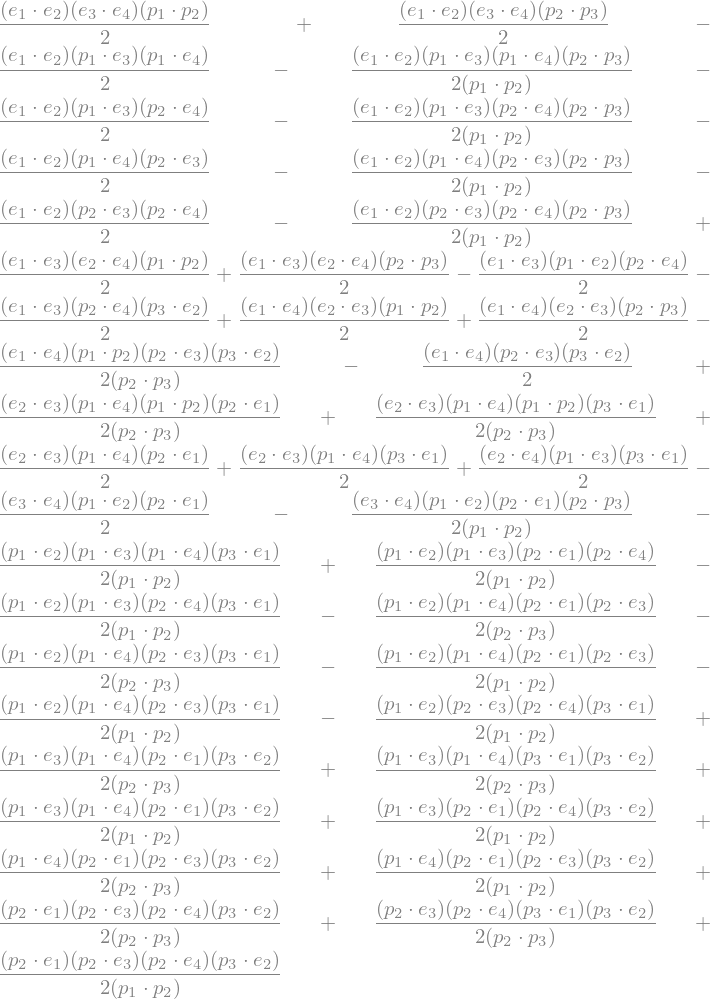

In [50]:
A3A3_ap_s_channel_1 = Eliminate_mom_massless((n123_gluon_ap*n134_gluon).expand().subs(Factorization_channel(n123_gluon_ap,n134_gluon,3,1)),n).expand()#.subs(p1p2,0) 
A3A3_ap_s_channel_1

n134_gluon_ap = Generate_ansatz(Index_swap_ansatz(ansatz_array_123_gluon_ap,[[1,3],[2,4]]),3).subs(a1,1)

A3A3_ap_s_channel_2 = Eliminate_mom_massless((n123_gluon*n134_gluon_ap).expand().subs(Factorization_channel(n123_gluon,n134_gluon_ap,3,1)),n).expand()#.subs(p1p2,0) 
A3A3_ap_s_channel_2

gluon_ap_fact_s_4pt = Solve_prefactors(n1234_gluon_ap_ansatz_const_4.subs(p1p2,0)-(A3A3_ap_s_channel_1+A3A3_ap_s_channel_2).subs(p1p2,0),four_gluon_ap_term_list)
print(gluon_ap_fact_s_4pt)

n1234_gluon_ap_ansatz_const_5 = n1234_gluon_ap_ansatz_const_4.subs(gluon_ap_fact_s_4pt)

n1234_gluon_ap_ansatz_u_channel_const_5 = n1234_gluon_ap_ansatz_u_channel_const_4.subs(gluon_ap_fact_s_4pt)

A1234_gluon_ap_ansatz_const_5 = A1234_gluon_ap_ansatz_const_4.subs(gluon_ap_fact_s_4pt)

A1234_gluon_ap_ansatz_const_5.expand()

There are some gauge parameters in the numerators. The amplitude is fully constrained.

To substitute mandelstams for gluon amplitude we need to do some things slightly differetn hence we have a seperate function

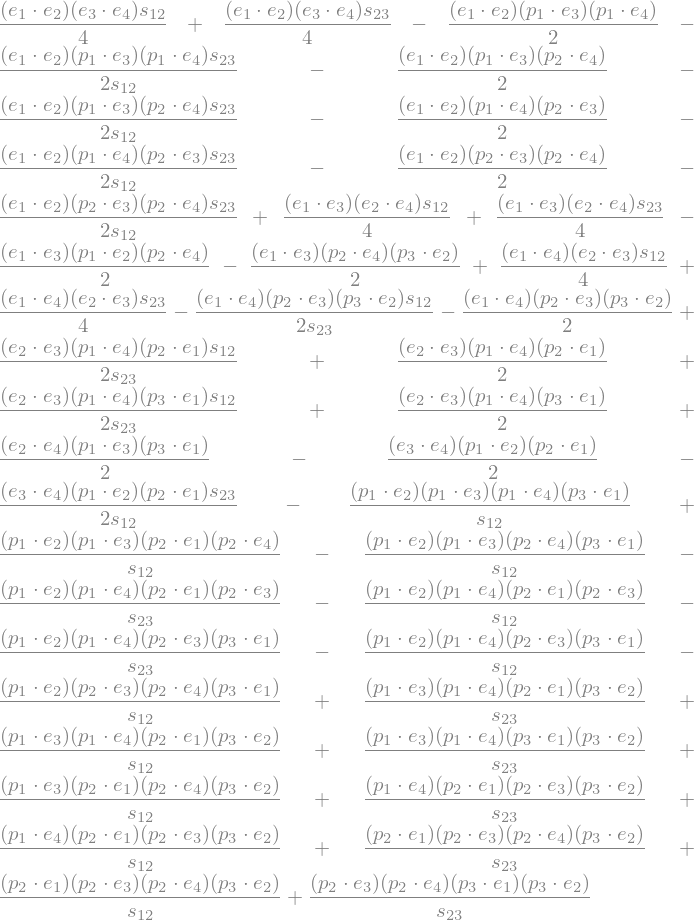

In [51]:
def Termwise_Mandelstam_Substitution_gluon(expression):
    s12 ,s13, s23, s24, s123, s234, m = symbols('s_{12} s_{13} s_{23} s_{24} s_{123} s_{234} m')

    """Cancel terms in an expression term by term"""
    new_expression = 0
    for term in expression.args:
        numerator = term.as_numer_denom()[0]
        numerator = numerator.subs(p2p3,s23/2).subs(p3p4,s34/2).subs(p2p4,s24/2).subs(p1p2,s12/2)
        denominator = term.as_numer_denom()[1]
        denominator = denominator.factor().subs((p2p3+p2p4+p3p4),s234/2).subs((p1p2+p1p3+p2p3),(s123)/2).subs(p1p2,(s12)/2).subs(p2p3,s23/2).subs(p3p4,s34/2)
        new_expression += numerator/denominator.factor()
    return new_expression
Termwise_Mandelstam_Substitution_gluon(A1234_gluon_ap_ansatz_const_5.expand())

### alpha prime squared pure gluon 4 pt

In [52]:
n = 4

# generate sympy symbols for kinematics
Generate_Symbols_kinematics_gluon(n)

# generate possible ansatz terms
ansatz_array_1234_gluon_ap2 = Generate_ansatz_n_gluon(n,n+2)
# print(ansatz_array_1234_gluon_ap2)

# generate ansatz
n1234_gluon_ap2_ansatz, four_gluon_ap2_term_list = Generate_ansatz(ansatz_array_1234_gluon_ap2,n,include_term_list=True)
len(n1234_gluon_ap2_ansatz.args)

In [53]:
n2134_gluon_ap2_ansatz = Eliminate_mom_massless(Generate_ansatz(Index_swap_ansatz(ansatz_array_1234_gluon_ap2,[[1,2]]),n),n).expand()
gluon_ap2_sym_const_1_4pt = Solve_prefactors(n2134_gluon_ap2_ansatz+n1234_gluon_ap2_ansatz,four_gluon_ap2_term_list)
n1234_gluon_ap2_ansatz_const_1 = n1234_gluon_ap2_ansatz.subs(gluon_ap2_sym_const_1_4pt)

In [54]:
n4321_gluon_ap2_ansatz_const_1 = Eliminate_mom_massless(Generate_ansatz(Index_swap_ansatz(ansatz_array_1234_gluon_ap2,[[1,4],[2,3]]),n).subs(gluon_ap2_sym_const_1_4pt),n).expand()
gluon_ap2_sym_const_2_4pt = Solve_prefactors(n4321_gluon_ap2_ansatz_const_1-n1234_gluon_ap2_ansatz_const_1,four_gluon_ap2_term_list)
n1234_gluon_ap2_ansatz_const_2 = n1234_gluon_ap2_ansatz_const_1.subs(gluon_ap2_sym_const_2_4pt)


In [55]:
n2314_gluon_ap2_ansatz_const_2 = Eliminate_mom_massless(Generate_ansatz(Index_swap_ansatz(ansatz_array_1234_gluon_ap2,[[1,2],[1,3]]),n),n).expand().subs(gluon_ap2_sym_const_1_4pt).subs(gluon_ap2_sym_const_2_4pt)
n3124_gluon_ap2_ansatz_const_2 = Eliminate_mom_massless(Generate_ansatz(Index_swap_ansatz(ansatz_array_1234_gluon_ap2,[[1,2],[2,3]]),n),n).expand().subs(gluon_ap2_sym_const_1_4pt).subs(gluon_ap2_sym_const_2_4pt)

gluon_ap2_jacobi_const_4pt = Solve_prefactors(n1234_gluon_ap2_ansatz_const_2 + n2314_gluon_ap2_ansatz_const_2 + n3124_gluon_ap2_ansatz_const_2,four_gluon_ap2_term_list)
print(gluon_ap2_jacobi_const_4pt)

n1234_gluon_ap2_ansatz_const_3 = n1234_gluon_ap2_ansatz_const_2.subs(gluon_ap2_jacobi_const_4pt)


{a_64: a_70 + a_72 + a_79, a_65: 2*a_71 + 2*a_79 - a_83/2 - a_9, a_66: a_70 + a_72 + a_79 - a_83/2, a_67: a_69 + a_8/2 + a_83/4 - a_9/2, a_14: 3*a_45 - 2*a_46 + 2*a_47, a_16: 2*a_45, a_92: 2*a_95 - 2*a_96 - 3*a_97 + 2*a_99, a_94: -a_97 + a_99, a_98: a_99}


In [56]:
# generate n1324 to construct the u-channel

n1324_gluon_ap2_ansatz_const_3 = Eliminate_mom_massless(Generate_ansatz(Index_swap_ansatz(ansatz_array_1234_gluon_ap2,[[2,3]]),n).subs(gluon_ap2_sym_const_1_4pt).subs(gluon_ap2_sym_const_2_4pt).subs(gluon_ap2_jacobi_const_4pt),n).expand()
# find u channel numerator
n1234_gluon_ap2_ansatz_u_channel_const_3 = n1234_gluon_ap2_ansatz_const_3 - n1324_gluon_ap2_ansatz_const_3

# find color ordered amplitude
A1234_gluon_ap2_ansatz_const_3 = (n1234_gluon_ap2_ansatz_const_3/(2*p1p2) + n1234_gluon_ap2_ansatz_u_channel_const_3/(2*p2p3)).expand()

# do the gauge transform e3 -> p3, this should make the amplitude vanish
A1234_gluon_ap2_ansatz_transformed = (Gauge_transform(A1234_gluon_ap2_ansatz_const_3,3,n)*p1p2*p2p3).expand()

# solve for the prefactors that make this amplitude vanish
gluon_ap2_gauge_const_4pt = Solve_prefactors(A1234_gluon_ap2_ansatz_transformed,Term_list_generator(A1234_gluon_ap2_ansatz_transformed))
print(gluon_ap2_gauge_const_4pt)
# constrain the numerator with the resulting constrains
n1234_gluon_ap2_ansatz_const_4 = n1234_gluon_ap2_ansatz_const_3.subs(gluon_ap2_gauge_const_4pt)
# n1234_gluon_ap2_ansatz_const_3
n1324_gluon_ap2_ansatz_const_4 = n1324_gluon_ap2_ansatz_const_3.subs(gluon_ap2_gauge_const_4pt)

A1234_gluon_ap2_ansatz_const_4 = A1234_gluon_ap2_ansatz_const_3.subs(gluon_ap2_gauge_const_4pt)

{a_45: a_9/2, a_46: 2*a_47 - a_9/2 - 2*a_95 + 2*a_96 + 4*a_99, a_48: -a_96 - a_99, a_68: -a_8/2 - a_83/4 + a_9/2 - 2*a_95 + a_99, a_69: -a_96 - a_99, a_70: -a_79 + a_83/2 + a_9 - a_99, a_71: -a_79 + a_9 - a_99, a_72: 0, a_97: a_99}


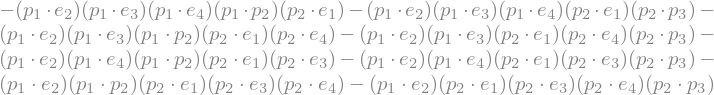

In [57]:
A3A3_ap2_s_channel = Eliminate_mom_massless((n123_gluon_ap*n134_gluon_ap).expand().subs(Factorization_channel(n123_gluon_ap,n134_gluon_ap,3,1)),n).expand()#.subs(p1p2,0) 
A3A3_ap2_s_channel

In [58]:
gluon_ap2_fact_s_4pt = Solve_prefactors(n1234_gluon_ap2_ansatz_const_4.subs(p1p2,0)-A3A3_ap2_s_channel.subs(p1p2,0),four_gluon_ap2_term_list)
print(gluon_ap2_fact_s_4pt)

n1234_gluon_ap2_ansatz_const_5 = n1234_gluon_ap2_ansatz_const_4.subs(gluon_ap2_fact_s_4pt)
# n1234_gluon_ap2_ansatz_const_4
n1324_gluon_ap2_ansatz_const_5 = n1324_gluon_ap2_ansatz_const_4.subs(gluon_ap2_fact_s_4pt)

A1234_gluon_ap2_ansatz_const_5 = A1234_gluon_ap2_ansatz_const_4.subs(gluon_ap2_fact_s_4pt)

{a_9: 0, a_95: -1/2, a_96: 0, a_99: 0}


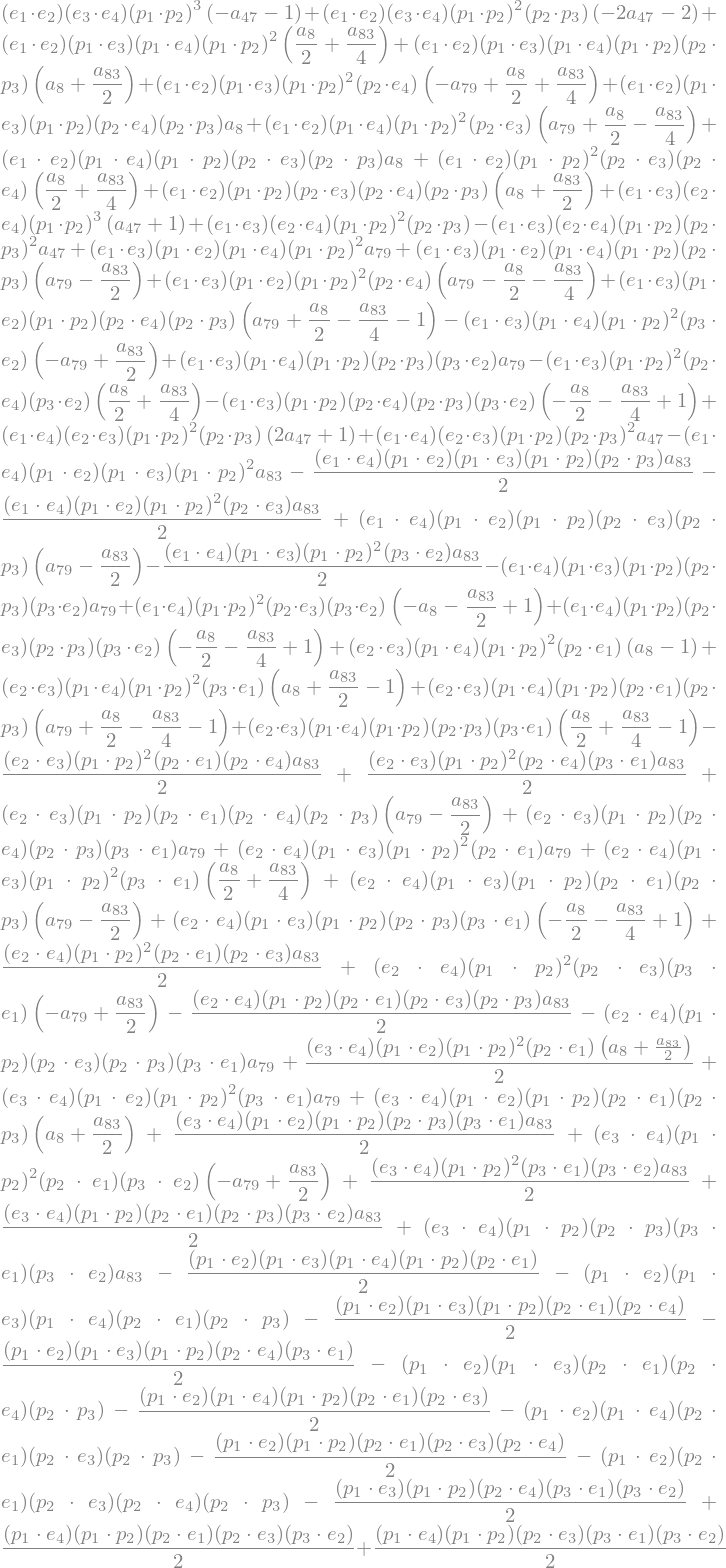

In [59]:
n1234_gluon_ap2_ansatz_const_5

This the numerator again, with only gauge paramters. The amplitude is:


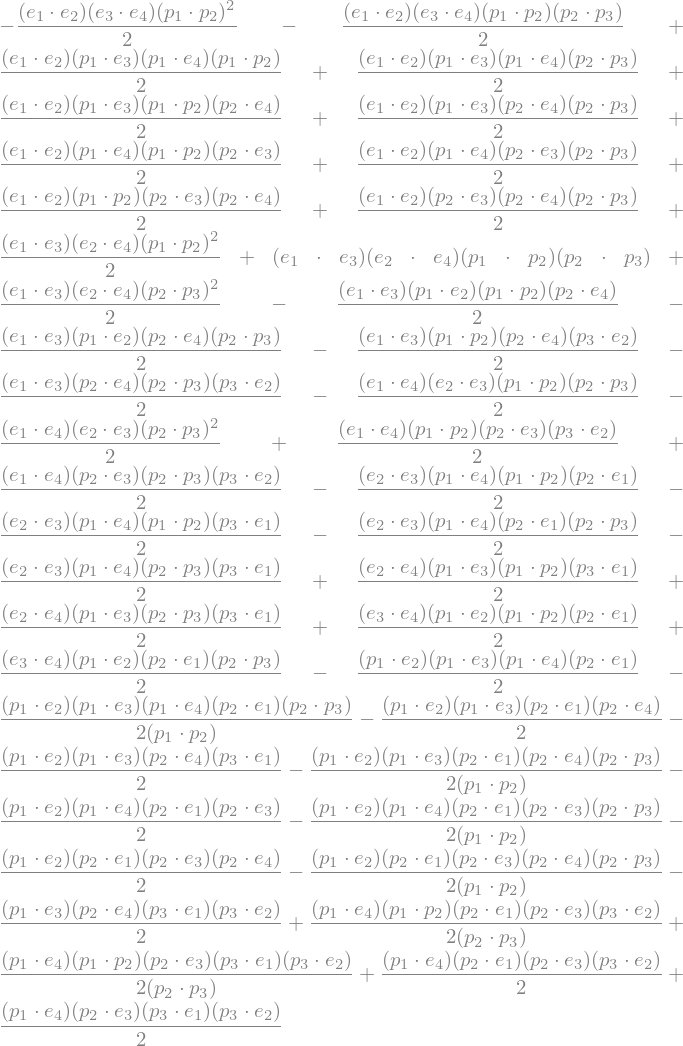

In [60]:
A1234_gluon_ap2 = A1234_gluon_ap2_ansatz_const_5.expand()
A1234_gluon_ap2

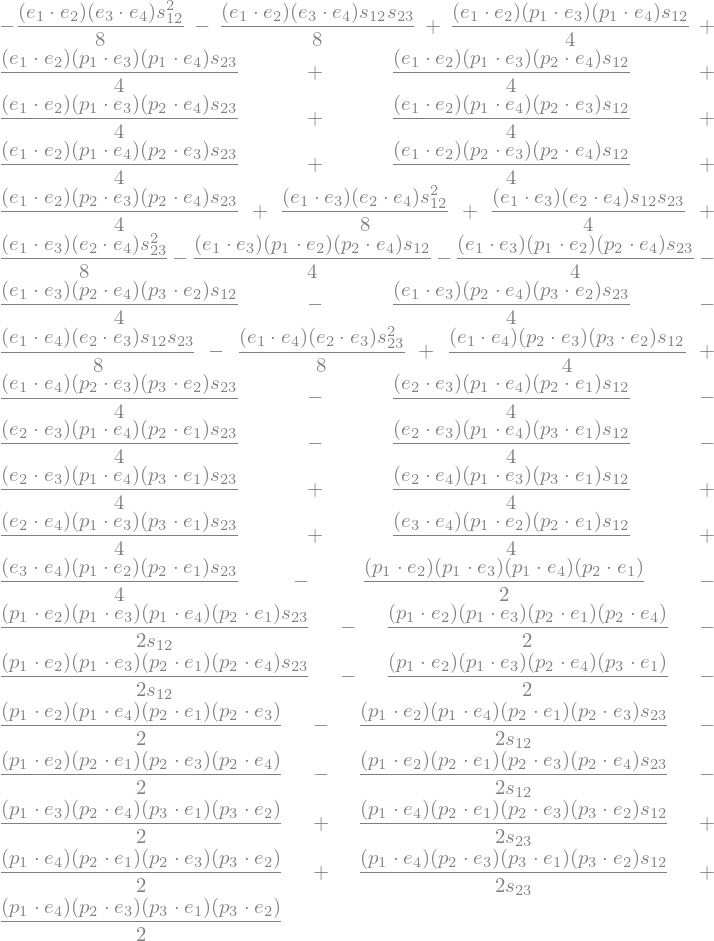

In [61]:
Termwise_Mandelstam_Substitution_gluon(A1234_gluon_ap2)

Interestingly there are only 4 terms in the s-channel, 2 in the u-channel and there rest are contact terms.

### 2 massive scalars 2 gluons F3

['e2e3', 'p1p2', 'p1p3', 'p1p4', 'p2p3', 'p2p4', 'p3p4', 'p1e2', 'p3e2', 'p4e2', 'p1e3', 'p2e3', 'p4e3', 's23', 've2', 've3', 'vp2', 'vp3', 'ke2', 'ke3', 'kp2', 'kp3', 'p1p1', 'p2p2', 'p3p3', 'p4p4']
['e2e3 p1p1 p1p1', 'e2e3 p1p1 p1p2', 'e2e3 p1p1 p2p3', 'e2e3 p1p2 p1p2', 'e2e3 p1p2 p2p3', 'e2e3 p2p3 p2p3', 'p1e2 p1e3 p1p1', 'p1e2 p1e3 p1p2', 'p1e2 p1e3 p2p3', 'p1e2 p2e3 p1p1', 'p1e2 p2e3 p1p2', 'p1e2 p2e3 p2p3', 'p1e3 p3e2 p1p1', 'p1e3 p3e2 p1p2', 'p1e3 p3e2 p2p3', 'p2e3 p3e2 p1p1', 'p2e3 p3e2 p1p2', 'p2e3 p3e2 p2p3']


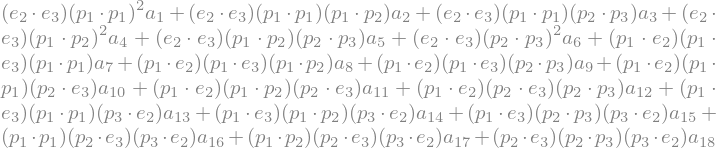

In [62]:
n = 4 

# generate sympy symbols for kinematics
Generate_Symbols_kinematics(n)

#generate possible ansatz terms
ansatz_array_1234_ap = Generate_ansatz_2_scalar_nmin2_gluon(n,n)
print(ansatz_array_1234_ap)

#generate ansatz
n1234_ap_ansatz, four_2m2g_ap_term_list = Generate_ansatz(ansatz_array_1234_ap,n,include_term_list=True)
n1234_ap_ansatz

{a_1: 0, a_2: 2*a_3, a_4: 0, a_5: 2*a_6, a_7: 0, a_8: 2*a_9, a_10: -a_13, a_11: a_14, a_12: a_14 - a_15, a_16: 0, a_17: 2*a_18}


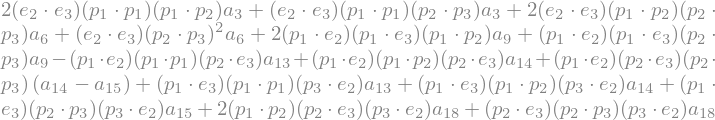

In [63]:
# generate the isomorphism
n1324_ap_ansatz = Eliminate_mom_massless(Generate_ansatz(Index_swap_ansatz(ansatz_array_1234_ap,[[2,3]]),n),n).expand()
n1324_ap_ansatz
# find constraints
massive_ap_sym_const_1_4pt = Solve_prefactors(n1234_ap_ansatz+n1324_ap_ansatz,four_2m2g_ap_term_list)
print(massive_ap_sym_const_1_4pt)

# apply constraints
n1234_ap_ansatz_const_1 = n1234_ap_ansatz.subs(massive_ap_sym_const_1_4pt)

# show constrained ansatz
n1234_ap_ansatz_const_1

{a_14: 0, a_15: 0, a_18: -a_6, a_9: 0, a_13: 0, a_3: 0}


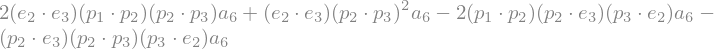

In [64]:
# calculate the color ordered amplitude 
A1234_ap_ansatz_const_1 = (n1234_ap_ansatz_const_1/(2*p2p3)).expand()
A1234_ap_ansatz_const_1

#transform the amplitude, again with e3 -> p3
A1234_ap_ansatz_transformed = (Gauge_transform(A1234_ap_ansatz_const_1,3,n,massless=False)*p2p3).expand()
A1234_ap_ansatz_transformed

# solve for vanishing amplitude
massive_ap_gauge_const_4pt = Solve_prefactors(A1234_ap_ansatz_transformed,Term_list_generator(A1234_ap_ansatz_transformed))
print(massive_ap_gauge_const_4pt)


# apply constraints
n1234_ap_ansatz_const_2 = n1234_ap_ansatz_const_1.subs(massive_ap_gauge_const_4pt)

# show constrained ansatz
n1234_ap_ansatz_const_2

{a_6: 1/2}


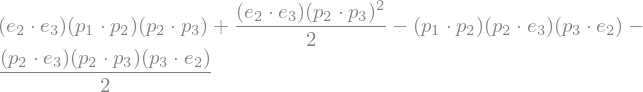

In [65]:
massive_ap_fact_const = Solve_prefactors(n1234_ap_ansatz_const_2.subs(p2p3,0)+n123_gluon_ap.subs(p1e2,p3e2).subs(p1e3,p2e3).subs(p2e1,p1p2),four_2m2g_ap_term_list)
print(massive_ap_fact_const)

n1234_ap = n1234_ap_ansatz_const_2.subs(massive_ap_fact_const)
n1234_ap

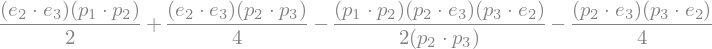

In [66]:
A1234_ap = (n1234_ap/(2*p2p3)).expand()
A1234_ap

This is the final amplitude

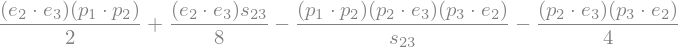

In [67]:
Termwise_Mandelstam_Substitution(A1234_ap.expand())

The Heft term is (correct with litterature):

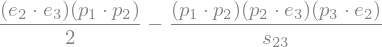

In [68]:
Termwise_Mandelstam_Substitution(Leading_order_HEFT_extractor(A1234_ap.expand()))

### 2 massive scalars 3 gluons F3

In [69]:
n = 5

# generate sympy symbols for kinematics
Generate_Symbols_kinematics(5)

#generate possible ansatz terms
ansatz_array_12345_ap = Generate_ansatz_2_scalar_nmin2_gluon(n,n)

#generate ansatz
nmml12345_ap_ansatz, five_2m3g_ap_term_list = Generate_ansatz(ansatz_array_12345_ap,n,include_term_list=True)
print(len(nmml12345_ap_ansatz.args))

['e2e3', 'e2e4', 'e3e4', 'p1p2', 'p1p3', 'p1p4', 'p1p5', 'p2p3', 'p2p4', 'p2p5', 'p3p4', 'p3p5', 'p4p5', 'p1e2', 'p3e2', 'p4e2', 'p5e2', 'p1e3', 'p2e3', 'p4e3', 'p5e3', 'p1e4', 'p2e4', 'p3e4', 'p5e4', 's23', 's234', 's34', 've2', 've3', 've4', 'vp2', 'vp3', 'vp4', 'ke2', 'ke3', 'ke4', 'kp2', 'kp3', 'kp4', 'p1p1', 'p2p2', 'p3p3', 'p4p4', 'p5p5']
351


In [70]:
nmml54321_ap_ansatz = Eliminate_mom_massive(Generate_ansatz(Index_swap_ansatz(ansatz_array_12345_ap,[[2,4],[1,5]]),n),n).expand()
nmml52341_ap_ansatz = Eliminate_mom_massive(Generate_ansatz(Index_swap_ansatz(ansatz_array_12345_ap,[[1,5]]),n),n).expand()
nmml14325_ap_ansatz = Eliminate_mom_massive(Generate_ansatz(Index_swap_ansatz(ansatz_array_12345_ap,[[2,4]]),n),n).expand()

nmlml12345_ap_ansatz = nmml12345_ap_ansatz - nmml52341_ap_ansatz
nmlml14325_ap_ansatz = nmml14325_ap_ansatz - nmml54321_ap_ansatz

A12345_ap_ansatz = (nmml12345_ap_ansatz/(2*p1p2*2*p3p4) - nmml54321_ap_ansatz/(2*p2p3*(2*p1p2+2*p1p3+2*p2p3)) + nmlml12345_ap_ansatz/((2*p2p3+2*p2p4+2*p3p4)*2*p3p4) + nmlml14325_ap_ansatz/(2*p2p3*(2*p2p3+2*p2p4+2*p3p4))).expand()

In [71]:
# generate the isomorphism
nmml12435_ap_ansatz = Eliminate_mom_massive(Generate_ansatz(Index_swap_ansatz(ansatz_array_12345_ap,[[3,4]]),n),n).expand()

# find constraints
massive_ap_sym_const_1_5pt = Solve_prefactors(nmml12345_ap_ansatz+nmml12435_ap_ansatz,five_2m3g_ap_term_list)
# print(massive_ap_sym_const_1_5pt)
print(len(massive_ap_sym_const_1_5pt))

# apply constraints
nmml12345_ap_ansatz_const_1 = nmml12345_ap_ansatz.subs(massive_ap_sym_const_1_5pt)
nmlml12345_ap_ansatz_const_1 = nmlml12345_ap_ansatz.subs(massive_ap_sym_const_1_5pt)
A12345_ap_ansatz_const_1 = A12345_ap_ansatz.subs(massive_ap_sym_const_1_5pt)

181


In [72]:

A12345_ap_ansatz_transformed = (Gauge_transform(A12345_ap_ansatz_const_1,3,n,massless=False)*(2*p1p2)*(2*p1p2+2*p1p3+2*p2p3)*(2*p3p4)*(2*p2p3+2*p2p4+2*p3p4)*(2*p2p3)).expand().cancel()

massive_ap_gauge_const_5pt = Solve_prefactors(A12345_ap_ansatz_transformed,Term_list_generator(A12345_ap_ansatz_transformed))
print(massive_ap_gauge_const_5pt)

nmml12345_ap_ansatz_const_2 = nmml12345_ap_ansatz_const_1.subs(massive_ap_gauge_const_5pt)
nmlml12345_ap_ansatz_const_2 = nmlml12345_ap_ansatz_const_1.subs(massive_ap_gauge_const_5pt)
A12345_ap_ansatz_const_2 = A12345_ap_ansatz_const_1.subs(massive_ap_gauge_const_5pt)

{a_136: -a_91 - a_92 + 2*a_93 + a_97, a_137: -a_243, a_144: -a_234 + a_242 - 2*a_243, a_145: 0, a_146: -a_242, a_147: -a_243, a_175: -a_91 + a_92 - a_97, a_176: a_300 - a_51 + 2*a_78 - a_83 + a_91 - a_92 - 3*a_94 + a_97, a_177: -a_330 - a_51 - a_74 + 2*a_78 - a_83 + 2*a_91 - 2*a_93 - 3*a_94 + a_95 + a_97 - a_99, a_178: -a_91 + a_93, a_179: -a_335 - a_347 - a_51 - a_74 + 2*a_78 - a_83 + 4*a_91 - 2*a_93 - 6*a_94, a_180: a_300 + a_78, a_181: a_300 - a_330 + a_81 + a_97, a_182: a_300 - a_336 + a_83, a_183: a_300 - a_348 + a_84, a_184: -a_330 + a_61 - a_78 + a_81 + a_97, a_185: -a_330 - a_337 + a_59 - 2*a_78 + a_81 + a_83 + a_97, a_186: -a_330 - a_349 + a_62 - 2*a_78 + a_81 + a_84 + a_97, a_187: 0, a_188: -a_350, a_189: -a_351, a_194: 0, a_195: 0, a_209: 0, a_210: 0, a_211: 0, a_212: 0, a_213: a_234, a_218: 0, a_219: 0, a_227: 0, a_228: 0, a_229: -a_234, a_230: 0, a_231: 0, a_233: 2*a_335 - 3*a_91 + 6*a_94, a_235: 0, a_236: 0, a_237: 0, a_263: 0, a_264: 0, a_265: -a_97, a_266: 0, a_267: -a_

In [73]:
A3L = n123
A3R = n123
A3T_ap = n134_gluon_ap
# properly sum over the states, the left over "p1" index corresond to the internal momentum which is actually p1+p2 
A4R_ap = (A3R*A3T_ap).expand().subs(Factorization_channel(A3R,A3T_ap,2,1)).subs(p1p3,p1p3+p2p3).expand()
A5_ap_double_cut_s12_s34 = (A3L*A4R_ap).expand()
A5_ap_double_cut_s12_s34

In [74]:
massive_ap_fact_double_cut_s12_s34_5pt = Solve_prefactors(nmml12345_ap_ansatz_const_2.subs(p1p2,0).subs(p3p4,0)-A5_ap_double_cut_s12_s34,five_2m3g_ap_term_list)
print(massive_ap_fact_double_cut_s12_s34_5pt)


nmml12345_ap_ansatz_const_3 = nmml12345_ap_ansatz_const_2.subs(massive_ap_fact_double_cut_s12_s34_5pt)
nmlml12345_ap_ansatz_const_3 = nmlml12345_ap_ansatz_const_2.subs(massive_ap_fact_double_cut_s12_s34_5pt)
A12345_ap_ansatz_const_3 = A12345_ap_ansatz_const_2.subs(massive_ap_fact_double_cut_s12_s34_5pt)

{a_300: 0, a_330: 0, a_336: 0, a_337: 0, a_59: 0, a_61: 0, a_78: 0, a_81: 0, a_83: 0, a_97: 0, a_98: 0, a_99: 0, a_69: 0, a_90: 0, a_234: 0, a_242: 0, a_243: 1/2, a_346: 0, a_348: 0, a_349: 0, a_350: 0}


In [75]:
cancelledamp = A12345_ap_ansatz_const_3.cancel()

Only Gauge parameters are left now. We cant really print this amplitude as it is too large as a whole.

With all gauge parameters set to zero it is:

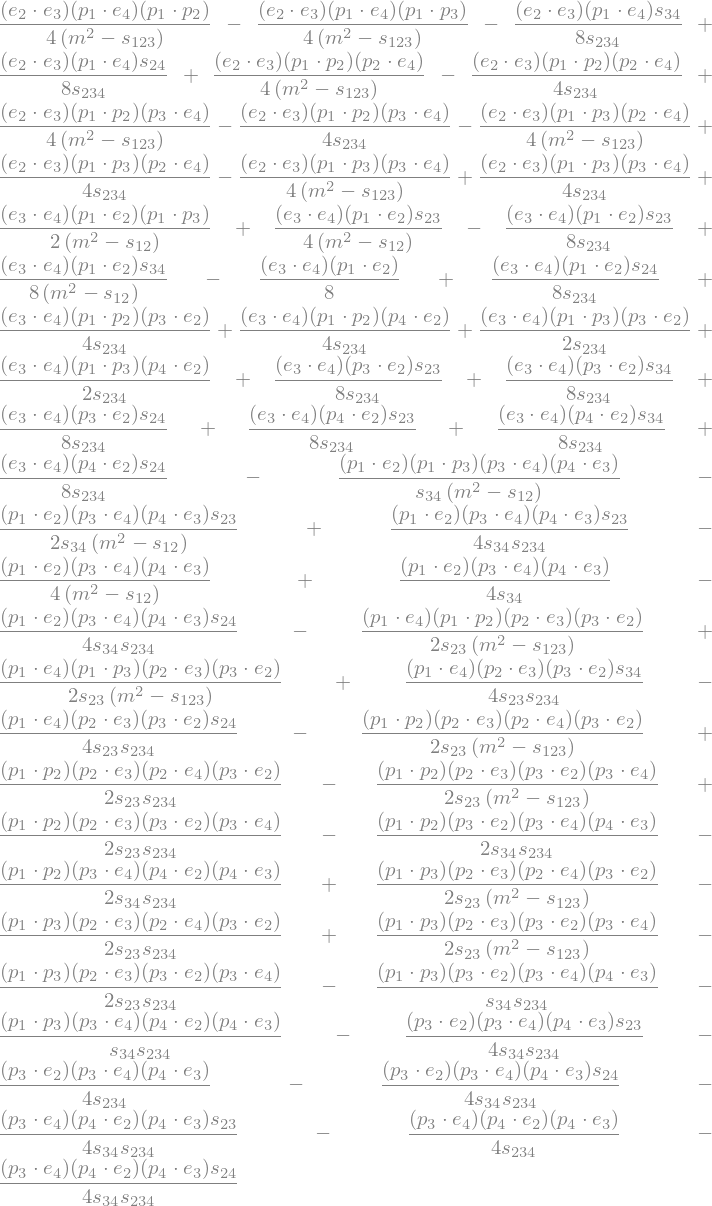

In [76]:
Termwise_Mandelstam_Substitution(A12345_ap_ansatz_const_3.subs(a91,0).subs(a94,0).subs(a92,0).subs(a93,0).subs(a74,0).subs(a84,0).subs(a51,0).subs(a335,0).subs(a95,0).subs(a62,0).subs(a351,0).subs(a347,0))

The HEFT expansion with all gauge parameters set equal 0:

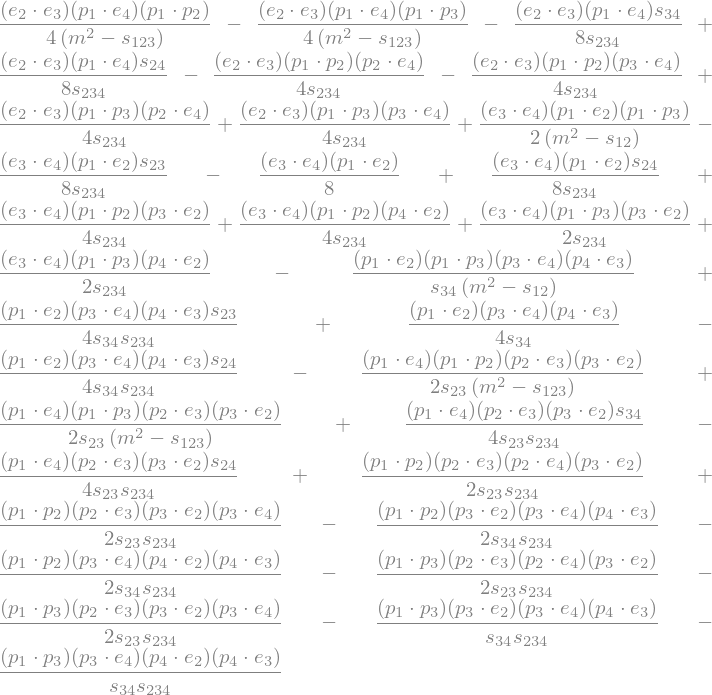

In [77]:
Termwise_Mandelstam_Substitution(Leading_order_HEFT_extractor(A12345_ap_ansatz_const_3.subs(a91,0).subs(a94,0).subs(a92,0).subs(a93,0).subs(a74,0).subs(a84,0).subs(a51,0).subs(a335,0).subs(a95,0).subs(a62,0).subs(a351,0).subs(a347,0)))

This concludes the notebook